# DAQL: Deep Adv/Auto Q-Learning 

In this notebook, you'll build a GAN using convolutional layers in the generator and discriminator. This is called a Deep Convolutional GAN, or DCGAN for short. The DCGAN architecture was first explored last year and has seen impressive results in generating new images, you can read the [original paper here](https://arxiv.org/pdf/1511.06434.pdf).

You'll be training DCGAN on the [Street View House Numbers](http://ufldl.stanford.edu/housenumbers/) (SVHN) dataset. These are color images of house numbers collected from Google street view. SVHN images are in color and much more variable than MNIST. 

![SVHN Examples](assets/SVHN_examples.png)

So, we'll need a deeper and more powerful network. This is accomplished through using convolutional layers in the discriminator and generator. It's also necessary to use batch normalization to get the convolutional networks to train. The only real changes compared to what [you saw previously](https://github.com/udacity/deep-learning/tree/master/gan_mnist) are in the generator and discriminator, otherwise the rest of the implementation is the same.

In [1]:
import tensorflow as tf
print('TensorFlow Version: {}'.format(tf.__version__))
print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.12.0
Default GPU Device: /device:GPU:0


In [2]:
%matplotlib inline

import pickle as pkl

import matplotlib.pyplot as plt
import numpy as np
from scipy.io import loadmat
import tensorflow as tf

In [3]:
!mkdir data

mkdir: cannot create directory ‘data’: File exists


## Getting the data

Here you can download the SVHN dataset. Run the cell above and it'll download to your machine.

In [4]:
from urllib.request import urlretrieve
from os.path import isfile, isdir
from tqdm import tqdm

data_dir = 'data/'

if not isdir(data_dir):
    raise Exception("Data directory doesn't exist!")

class DLProgress(tqdm):
    last_block = 0

    def hook(self, block_num=1, block_size=1, total_size=None):
        self.total = total_size
        self.update((block_num - self.last_block) * block_size)
        self.last_block = block_num

if not isfile(data_dir + "train_32x32.mat"):
    with DLProgress(unit='B', unit_scale=True, miniters=1, desc='SVHN Training Set') as pbar:
        urlretrieve(
            'http://ufldl.stanford.edu/housenumbers/train_32x32.mat',
            data_dir + 'train_32x32.mat',
            pbar.hook)

if not isfile(data_dir + "test_32x32.mat"):
    with DLProgress(unit='B', unit_scale=True, miniters=1, desc='SVHN Testing Set') as pbar:
        urlretrieve(
            'http://ufldl.stanford.edu/housenumbers/test_32x32.mat',
            data_dir + 'test_32x32.mat',
            pbar.hook)

These SVHN files are `.mat` files typically used with Matlab. However, we can load them in with `scipy.io.loadmat` which we imported above.

In [5]:
trainset = loadmat(data_dir + 'train_32x32.mat')
testset = loadmat(data_dir + 'test_32x32.mat')

In [6]:
trainset.keys(), trainset['y'].shape

(dict_keys(['__header__', '__version__', '__globals__', 'X', 'y']), (73257, 1))

In [7]:
trainset['X'].shape

(32, 32, 3, 73257)

In [8]:
trainset['y'].dtype

dtype('uint8')

In [9]:
y_dim = max(trainset['y'])[0] # number of classes

Here I'm showing a small sample of the images. Each of these is 32x32 with 3 color channels (RGB). These are the real images we'll pass to the discriminator and what the generator will eventually fake.

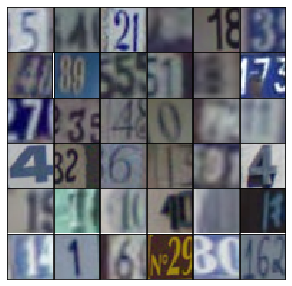

In [10]:
idx = np.random.randint(0, trainset['X'].shape[3], size=36)
fig, axes = plt.subplots(6, 6, sharex=True, sharey=True, figsize=(5,5),)
for ii, ax in zip(idx, axes.flatten()):
    ax.imshow(trainset['X'][:,:,:,ii], aspect='equal')
    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)
plt.subplots_adjust(wspace=0, hspace=0)

Here we need to do a bit of preprocessing and getting the images into a form where we can pass batches to the network. 
First off, we need to rescale the images to a range of -1 to 1, since the output of our generator is also in that range. 
We also have a set of test and validation images which could be used if we're trying to identify the numbers in the images.

In [11]:
# Scale works the same as tanh
def scale(x, feature_range=(-1, 1)):
    # scale to (0, 1)
    x = ((x - x.min())/(255 - x.min()))
    
    # scale to feature_range
    min_, max_ = feature_range
    x = x * (max_ - min_) + min_
    return x # scaled to [-1, 1]

In [12]:
class Dataset:
    def __init__(self, train, test, val_frac=0.5, shuffle=False, scale_func=None):
        split_idx = int(len(test['y'])*(1 - val_frac))
        self.test_x, self.valid_x = test['X'][:,:,:,:split_idx], test['X'][:,:,:,split_idx:]
        self.test_y, self.valid_y = test['y'][:split_idx], test['y'][split_idx:]
        self.train_x, self.train_y = train['X'], train['y']
        
        self.train_x = np.rollaxis(self.train_x, 3)
        self.valid_x = np.rollaxis(self.valid_x, 3)
        self.test_x = np.rollaxis(self.test_x, 3)
        
        if scale_func is None:
            self.scaler = scale
        else:
            self.scaler = scale_func
        self.shuffle = shuffle
        
    def batches(self, batch_size):
        if self.shuffle:
            idx = np.arange(len(self.train_x))
            np.random.shuffle(idx)
            self.train_x = self.train_x[idx]
            self.train_y = self.train_y[idx]
        
        n_batches = len(self.train_y)//batch_size
        for ii in range(0, len(self.train_y), batch_size):
            x = self.train_x[ii:ii+batch_size]
            y = self.train_y[ii:ii+batch_size]
            
            yield self.scaler(x), y

In [13]:
# testset['X']

## Network Inputs

Here, just creating some placeholders like normal.

In [14]:
def model_inputs(x_dim):
    x = tf.placeholder(tf.float32, [None, *x_dim], name='x_input')    
    is_training = tf.placeholder(tf.bool)
    return x, is_training

## Generator

Here you'll build the generator network. The input will be our noise vector `z` as before. Also as before, the output will be a $tanh$ output, but this time with size 32x32 which is the size of our SVHN images.

What's new here is we'll use convolutional layers to create our new images. The first layer is a fully connected layer which is reshaped into a deep and narrow layer, something like 4x4x1024 as in the original DCGAN paper. Then we use batch normalization and a leaky ReLU activation. Next is a transposed convolution where typically you'd halve the depth and double the width and height of the previous layer. Again, we use batch normalization and leaky ReLU. For each of these layers, the general scheme is convolution > batch norm > leaky ReLU.

You keep stacking layers up like this until you get the final transposed convolution layer with shape 32x32x3. Below is the archicture used in the original DCGAN paper:

![DCGAN Generator](assets/dcgan.png)

Note that the final layer here is 64x64x3, while for our SVHN dataset, we only want it to be 32x32x3.

In [15]:
def init_xavier(x, random_seed=1):
    return tf.contrib.layers.xavier_initializer(
        uniform=False, # normal and not uniform
        seed=tf.set_random_seed(seed=random_seed),
        dtype=x.dtype)

In [16]:
def conv2d(x, H, trainable=True):
    return tf.layers.conv2d(
        inputs=x,
        filters=H, #H: hidden dim, h: hidden layer
        kernel_size=5,
        strides=2, #(1, 1),
        padding='same', # NOT 'valid'
        data_format='channels_last', #NHWC not NCHW
        dilation_rate=(1, 1),
        activation=None,
        use_bias=True,
        kernel_initializer=init_xavier(x=x), # added normal xavier NOT uniform xavier
        bias_initializer=tf.zeros_initializer(),
        kernel_regularizer=None,
        bias_regularizer=None,
        activity_regularizer=None,
        kernel_constraint=None,
        bias_constraint=None,
        trainable=trainable, # variable
        name=None,
        reuse=None)

In [17]:
def conv2d_t(x, H, trainable=True):
    return tf.layers.conv2d_transpose(
        inputs=x,
        filters=H,
        kernel_size=5,
        strides=2, #(1, 1),
        padding='same', # NOT 'valid'
        data_format='channels_last', #NHWC not NCHW
        #dilation_rate=(1, 1), # does NOT exit in conv_transpose
        activation=None,
        use_bias=True,
        kernel_initializer=init_xavier(x=x), # added normal xavier NOT uniform xavier
        bias_initializer=tf.zeros_initializer(),
        kernel_regularizer=None,
        bias_regularizer=None,
        activity_regularizer=None,
        kernel_constraint=None,
        bias_constraint=None,
        trainable=trainable, ### variable
        name=None,
        reuse=None)

In [18]:
# (H, W, \
#  C) = 12, 24, 3

In [19]:
# x = tf.placeholder(tf.float16, [None, H, W, C])

In [20]:
# x

In [21]:
# conv2d(x, h=64)

In [22]:
# conv2d_t(x, h=1)

In [23]:
def mlp(x, H, trainable=True):
    return tf.layers.dense(
        inputs=x,
        units=H, #H: hidden dim
        activation=None,
        use_bias=True,
        kernel_initializer=init_xavier(x),
        bias_initializer=tf.zeros_initializer(),
        kernel_regularizer=None,
        bias_regularizer=None,
        activity_regularizer=None,
        kernel_constraint=None,
        bias_constraint=None,
        trainable=trainable,
        name=None,
        reuse=None)

In [24]:
def bn(x, training):
    return tf.layers.batch_normalization(
        inputs=x,
        axis=-1,
        momentum=0.99,
        epsilon=0.001,
        center=True,
        scale=True,
        beta_initializer=tf.zeros_initializer(),
        gamma_initializer=tf.ones_initializer(),
        moving_mean_initializer=tf.zeros_initializer(),
        moving_variance_initializer=tf.ones_initializer(),
        beta_regularizer=None,
        gamma_regularizer=None,
        beta_constraint=None,
        gamma_constraint=None,
        training=training, ######### variable/adjustable
        trainable=True,
        name=None,
        reuse=None,
        renorm=False,
        renorm_clipping=None,
        renorm_momentum=0.99,
        fused=None,
        virtual_batch_size=None,
        adjustment=None)

In [25]:
# tf.nn.leaky_relu(
#     features,
#     alpha=0.2,
#     name=None)
def nl(x, alpha=0.2):
    return tf.maximum(alpha * x, x)

In [26]:
# Generative model: Adv/Auto learning/encoder
def G(x, x_ch, reuse=False, alpha=0.1, training=True, trainable=False):
    with tf.variable_scope('G', reuse=reuse):
        # Input/encoding layers is 32x32x3
        print(x.shape)
        h = conv2d(x, 64, trainable)
        print(h.shape)
        # 16x16x64
        h = conv2d(h, 128, trainable)
        print(h.shape)
        # 8x8x128
        h = conv2d(h, 256, trainable)
        print(h.shape)
        # 4x4x256

        # FC/MLP layer: latent/hidden variables/state
        h_vec = tf.reshape(h, (-1, 4*4*256))
        z_vec = mlp(h_vec, 4*4*512, trainable) # z: noise/noiZ
        z = tf.reshape(z_vec, (-1, 4, 4, 512))
        print('h_vec, z_vec, z:', h_vec.shape, z_vec.shape, z.shape)
        # 4x4x512 now

        # Output/decoding layers
        h = conv2d_t(z, 256)
        h = bn(h, training)
        h = nl(h, alpha)
        print(h.shape)
        # 8x8x256 now
        h = conv2d_t(h, 128)
        h = bn(h, training)
        h = nl(h, alpha)
        print(h.shape)
        # 16x16x128 now
        h = conv2d_t(h, x_ch)
        x_ = tf.tanh(h) # predicted/reconst/gen x
        print(x_.shape)
        # 32x32x3 now
        return x_

## Discriminator

Here you'll build the discriminator. This is basically just a convolutional classifier like you've build before. The input to the discriminator are 32x32x3 tensors/images. You'll want a few convolutional layers, then a fully connected layer for the output. As before, we want a sigmoid output, and you'll need to return the logits as well. For the depths of the convolutional layers I suggest starting with 16, 32, 64 filters in the first layer, then double the depth as you add layers. Note that in the DCGAN paper, they did all the downsampling using only strided convolutional layers with no maxpool layers.

You'll also want to use batch normalization with `tf.layers.batch_normalization` on each layer except the first convolutional and output layers. Again, each layer should look something like convolution > batch norm > leaky ReLU. 

Note: in this project, your batch normalization layers will always use batch statistics. (That is, always set `training` to `True`.) That's because we are only interested in using the discriminator to help train the generator. However, if you wanted to use the discriminator for inference later, then you would need to set the `training` parameter appropriately.

In [27]:
# Discriminative/Q function/Q Net
def D(x, y_dim, reuse=False, alpha=0.1, training=True, trainable=False):
    with tf.variable_scope('D', reuse=reuse):
        # Input/encoding layers is 32x32x3
        print(x.shape)
        h = conv2d(x, 64, trainable)
        # h = bn(h, training)
        # h = nl(h, alpha)
        print(h.shape)
        # 16x16x64
        h = conv2d(h, 128, trainable)
        # h = bn(h, training)
        # h = nl(h, alpha)
        print(h.shape)
        # 8x8x128
        h = conv2d(h, 256, trainable)
        # h = bn(h, training)
        # h = nl(h, alpha)
        print(h.shape)
        # 4x4x256

        # FC/MLP layer/ output layer
        h_vec = tf.reshape(h, (-1, 4*4*256))
        y = mlp(h_vec, y_dim, trainable) # q-value
        print(y.shape)
        return y # y is q-value

## Model Loss

Calculating the loss like before, nothing new here.

In [28]:
def model_loss(x, x_ch, y_dim, is_training, alpha=0.1):
    """
    Get the loss for the discriminator and generator
    :param x: Images from the real dataset
    :param x_ch: The number of channels in the predicted/output image
    :return: A tuple of (generator loss, discriminators losses)
    """
    x_ = G(x=x, x_ch=x_ch, alpha=alpha, training=is_training) # x_gen/x_fake/x_recon/x_pred
    y_ = D(x=x_, y_dim=y_dim, alpha=alpha, training=is_training)
    
    y = D(x=x, y_dim=y_dim, alpha=alpha, training=is_training, reuse=True)
    
    loss = tf.reduce_mean(tf.reduce_sum((y-y_), axis=1))
    #loss = tf.reduce_mean(tf.reduce_sum((y-y_)**2, axis=1))
    # print(tf.reduce_mean(tf.reduce_sum((y-y_)**2, axis=1)).shape)
    # print((tf.reduce_sum((y-y_)**2, axis=1)).shape)
    # print((((y-y_)**2)).shape)
    # print((((y-y_))).shape)
    
    return loss, x_

## Optimizers

Not much new here, but notice how the train operations are wrapped in a `with tf.control_dependencies` block so the batch normalization layers can update their population statistics.

In [29]:
def model_opt(loss, learning_rate, beta1):
    """
    Get optimization operations
    :param g_loss: Generator loss
    :param d_loss: Discriminators loss
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (generator training operation, discriminators training operation)
    """
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    g_vars = [var for var in t_vars if var.name.startswith('G')]
    d_vars = [var for var in t_vars if var.name.startswith('D')]
    
    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        g_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(loss, var_list=g_vars)
        d_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(loss, var_list=g_vars)
        
    return g_opt, d_opt

## Building the model

Here we can use the functions we defined about to build the model as a class. This will make it easier to move the network around in our code since the nodes and operations in the graph are packaged in one object.

In [30]:
class DAQL:
    def __init__(self, x_dim, y_dim, learning_rate, alpha=0.2, beta1=0.5):
        
        self.x, self.is_training = model_inputs(x_dim=x_dim)
        
        # i, j, k OR H, W, C/D
        # x_dim=NXD, D:dim, D==HWC, H: height, W:width, C:channel/ch, D can also be Depth/Channels
        self.loss, self.x_ = model_loss(x=self.x, x_ch=x_dim[2], y_dim=y_dim, alpha=alpha, 
                                        is_training=self.is_training)
        
        self.g_opt, self.d_opt = model_opt(loss=self.loss, learning_rate=learning_rate, beta1=beta1)

Here is a function for displaying generated images.

In [31]:
def view_samples(epoch, samples, nrows, ncols, figsize=(5,5)):
    fig, axes = plt.subplots(figsize=figsize, nrows=nrows, ncols=ncols, 
                             sharey=True, sharex=True)
    for ax, img in zip(axes.flatten(), samples[epoch]):
        ax.axis('off')
        img = ((img - img.min())*255 / (img.max() - img.min())).astype(np.uint8)
        #ax.set_adjustable('box-forced')
        im = ax.imshow(img, aspect='equal')
   
    plt.subplots_adjust(wspace=0, hspace=0)
    return fig, axes

And another function we can use to train our network. Notice when we call `generator` to create the samples to display, we set `training` to `False`. That's so the batch normalization layers will use the population statistics rather than the batch statistics. Also notice that we set the `net.input_real` placeholder when we run the generator's optimizer. The generator doesn't actually use it, but we'd get an error without it because of the `tf.control_dependencies` block we created in `model_opt`. 

In [32]:
def train(net, dataset, epochs, batch_size, graph, print_every=20, show_every=200, figsize=(15,10)):
    saver = tf.train.Saver()
    samples, losses = [], []

    with tf.Session(graph=graph) as sess:
        sess.run(tf.global_variables_initializer())
        steps = 0

        # Episodes/epochs
        for epoch in range(epochs):
            
            # time steps or minibatches/batches
            for x, _ in dataset.batches(batch_size):

                # Training/learning
                feed_dict={net.x: x, net.is_training: True}
                #dloss, _ = sess.run([net.loss, net.d_opt], feed_dict)
                dloss = sess.run(net.loss, feed_dict)
                gloss, _ = sess.run([net.loss, net.g_opt], feed_dict)
                
                # Save losses to view after training
                losses.append([dloss, gloss])

                steps += 1
                if steps % print_every == 0:
                    print("Epoch {}/{}...".format(epoch+1, epochs),
                          "Dloss: {:.4f}".format(dloss),
                          "Gloss: {:.4f}".format(gloss))
                    

                if steps % show_every == 0:
                    x_ = sess.run(net.x_, feed_dict={net.x: x, net.is_training: False})
                    ##############
                    samples.append(x_) #x_generated/predicted
                    ###############
                    _ = view_samples(-1, samples, 6, 12, figsize=figsize)
                    ############
                    plt.show()

        #saver.save(sess, './checkpoints/generator.ckpt')
        # with open('samples.pkl', 'wb') as f:
        #     pkl.dump(samples, f)
    
    return losses, samples

## Hyperparameters

GANs are very sensitive to hyperparameters. A lot of experimentation goes into finding the best hyperparameters such that the generator and discriminator don't overpower each other. Try out your own hyperparameters or read [the DCGAN paper](https://arxiv.org/pdf/1511.06434.pdf) to see what worked for them.

In [33]:
y_dim = max(trainset['y'])[0]
x_dim = (32,32,3) # x_NxD, D: dim, D: HWC, C:channel/ch, D is not Depth
learning_rate = 0.0002
batch_size = 128
epochs = 111
alpha = 0.2
beta1 = 0.5

graph = tf.reset_default_graph()

net = DAQL(x_dim=x_dim, y_dim=y_dim, learning_rate=learning_rate, alpha=alpha, beta1=beta1)

dataset = Dataset(trainset, testset)

(?, 32, 32, 3)
(?, 16, 16, 64)
(?, 8, 8, 128)
(?, 4, 4, 256)
h_vec, z_vec, z: (?, 4096) (?, 8192) (?, 4, 4, 512)
(?, 8, 8, 256)
(?, 16, 16, 128)
(?, 32, 32, 3)
(?, 32, 32, 3)
(?, 16, 16, 64)
(?, 8, 8, 128)
(?, 4, 4, 256)
(?, 10)
(?, 32, 32, 3)
(?, 16, 16, 64)
(?, 8, 8, 128)
(?, 4, 4, 256)
(?, 10)


In [34]:
y_dim

10

In [35]:
dataset.test_y.shape, dataset.test_y.dtype 

((13016, 1), dtype('uint8'))

Epoch 1/111... Dloss: -17.6725 Gloss: -17.6725
Epoch 1/111... Dloss: -21.6669 Gloss: -21.6669
Epoch 1/111... Dloss: -23.5651 Gloss: -23.5651
Epoch 1/111... Dloss: -24.2539 Gloss: -24.2539
Epoch 1/111... Dloss: -25.0022 Gloss: -25.0022
Epoch 1/111... Dloss: -26.7784 Gloss: -26.7784
Epoch 1/111... Dloss: -26.5358 Gloss: -26.5358
Epoch 1/111... Dloss: -27.1988 Gloss: -27.1988
Epoch 1/111... Dloss: -27.3558 Gloss: -27.3558
Epoch 1/111... Dloss: -27.8319 Gloss: -27.8319


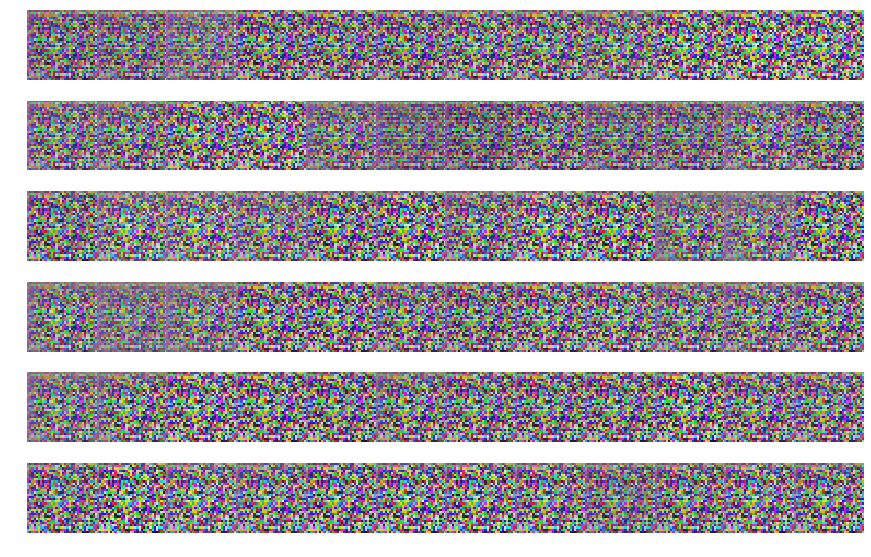

Epoch 1/111... Dloss: -27.8956 Gloss: -27.8956
Epoch 1/111... Dloss: -27.8396 Gloss: -27.8396
Epoch 1/111... Dloss: -28.0817 Gloss: -28.0817
Epoch 1/111... Dloss: -28.0217 Gloss: -28.0217
Epoch 1/111... Dloss: -27.9277 Gloss: -27.9277
Epoch 1/111... Dloss: -27.8936 Gloss: -27.8936
Epoch 1/111... Dloss: -28.0639 Gloss: -28.0639
Epoch 1/111... Dloss: -28.1908 Gloss: -28.1908
Epoch 1/111... Dloss: -28.0592 Gloss: -28.0592
Epoch 1/111... Dloss: -28.2154 Gloss: -28.2154


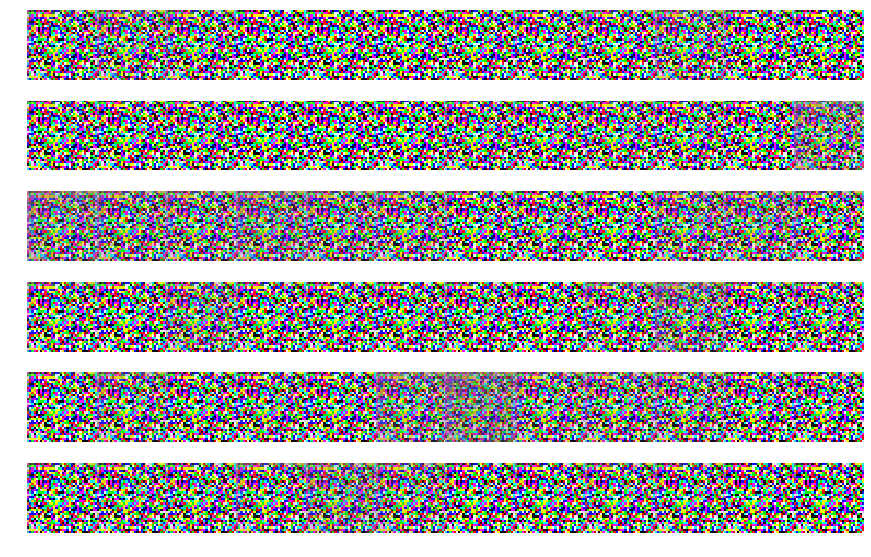

Epoch 1/111... Dloss: -28.2699 Gloss: -28.2699
Epoch 1/111... Dloss: -28.1894 Gloss: -28.1894
Epoch 1/111... Dloss: -28.2346 Gloss: -28.2346
Epoch 1/111... Dloss: -28.2697 Gloss: -28.2697
Epoch 1/111... Dloss: -28.3229 Gloss: -28.3229
Epoch 1/111... Dloss: -28.3645 Gloss: -28.3645
Epoch 1/111... Dloss: -28.3912 Gloss: -28.3912
Epoch 1/111... Dloss: -28.3618 Gloss: -28.3618
Epoch 2/111... Dloss: -28.2958 Gloss: -28.2958
Epoch 2/111... Dloss: -28.2830 Gloss: -28.2830


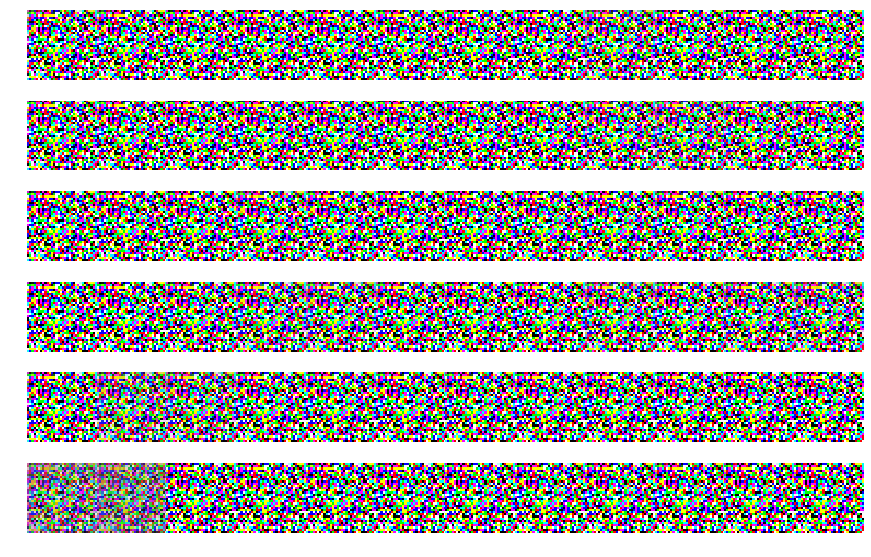

Epoch 2/111... Dloss: -28.4161 Gloss: -28.4161
Epoch 2/111... Dloss: -28.4285 Gloss: -28.4285
Epoch 2/111... Dloss: -28.4046 Gloss: -28.4046
Epoch 2/111... Dloss: -28.3873 Gloss: -28.3873
Epoch 2/111... Dloss: -28.3991 Gloss: -28.3991
Epoch 2/111... Dloss: -28.3856 Gloss: -28.3856
Epoch 2/111... Dloss: -28.4765 Gloss: -28.4765
Epoch 2/111... Dloss: -28.4499 Gloss: -28.4499
Epoch 2/111... Dloss: -28.4803 Gloss: -28.4803
Epoch 2/111... Dloss: -28.3613 Gloss: -28.3613


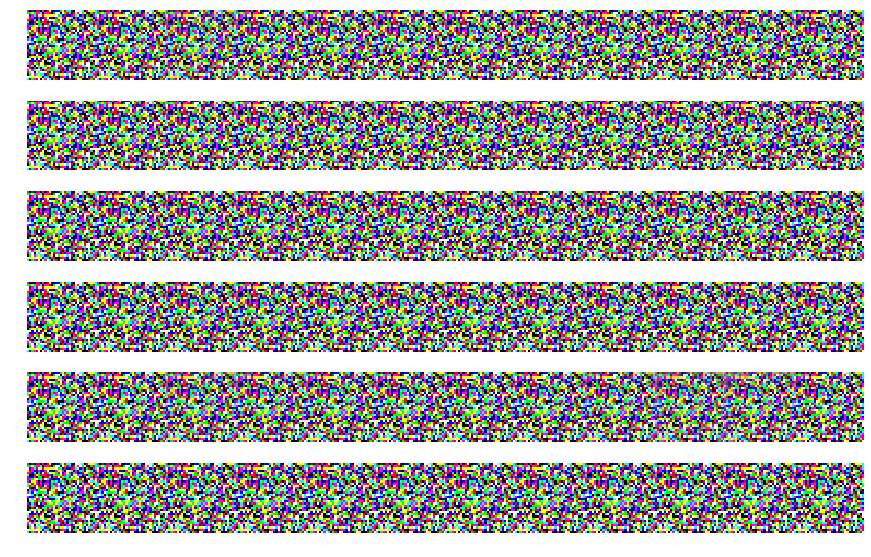

Epoch 2/111... Dloss: -28.3623 Gloss: -28.3623
Epoch 2/111... Dloss: -28.4251 Gloss: -28.4251
Epoch 2/111... Dloss: -28.4867 Gloss: -28.4867
Epoch 2/111... Dloss: -28.4861 Gloss: -28.4861
Epoch 2/111... Dloss: -28.4664 Gloss: -28.4664
Epoch 2/111... Dloss: -28.4960 Gloss: -28.4960
Epoch 2/111... Dloss: -28.4862 Gloss: -28.4862
Epoch 2/111... Dloss: -28.4868 Gloss: -28.4868
Epoch 2/111... Dloss: -28.4679 Gloss: -28.4679
Epoch 2/111... Dloss: -28.5008 Gloss: -28.5008


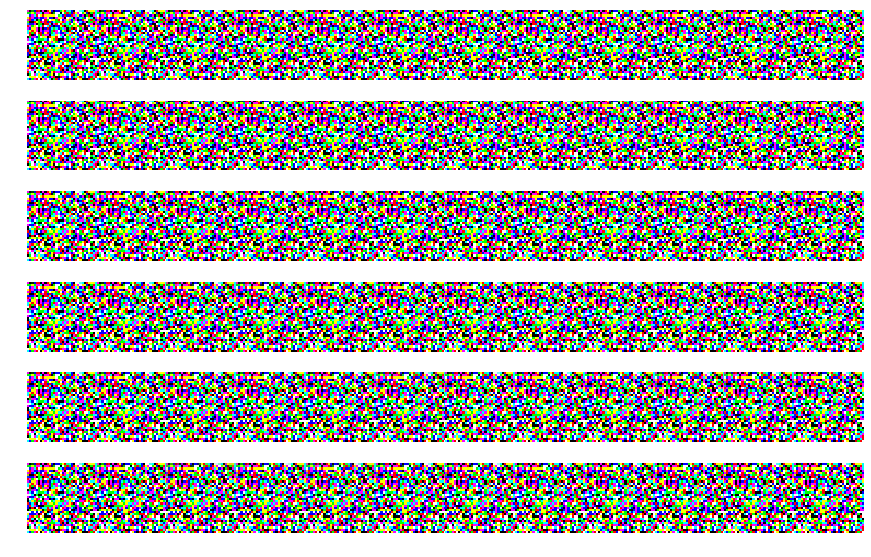

Epoch 2/111... Dloss: -28.4458 Gloss: -28.4458
Epoch 2/111... Dloss: -28.5281 Gloss: -28.5281
Epoch 2/111... Dloss: -28.4708 Gloss: -28.4708
Epoch 2/111... Dloss: -28.3825 Gloss: -28.3825
Epoch 2/111... Dloss: -28.4482 Gloss: -28.4482
Epoch 2/111... Dloss: -28.4827 Gloss: -28.4827
Epoch 2/111... Dloss: -28.5303 Gloss: -28.5303
Epoch 3/111... Dloss: -28.4863 Gloss: -28.4863
Epoch 3/111... Dloss: -28.4523 Gloss: -28.4523
Epoch 3/111... Dloss: -28.5193 Gloss: -28.5193


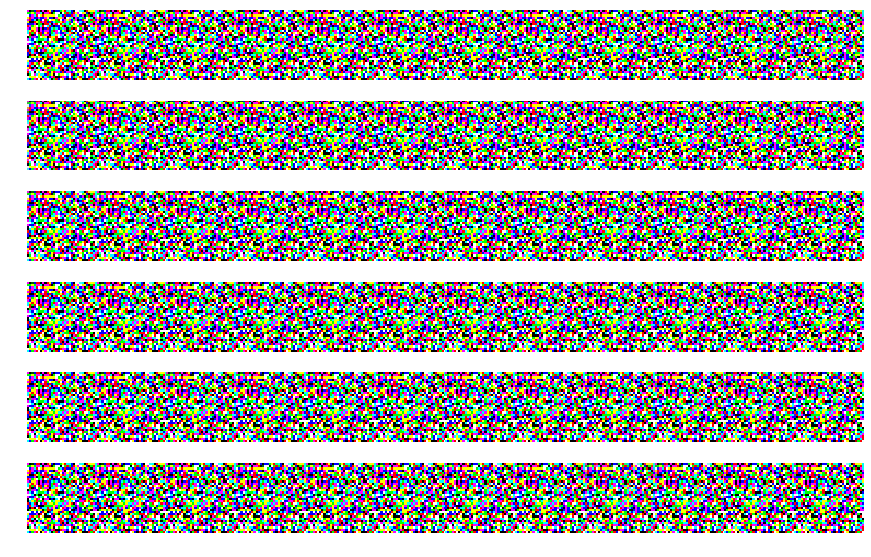

Epoch 3/111... Dloss: -28.5184 Gloss: -28.5184
Epoch 3/111... Dloss: -28.4849 Gloss: -28.4849
Epoch 3/111... Dloss: -28.5018 Gloss: -28.5018
Epoch 3/111... Dloss: -28.4835 Gloss: -28.4835
Epoch 3/111... Dloss: -28.4802 Gloss: -28.4802
Epoch 3/111... Dloss: -28.4906 Gloss: -28.4906
Epoch 3/111... Dloss: -28.4950 Gloss: -28.4950
Epoch 3/111... Dloss: -28.5359 Gloss: -28.5359
Epoch 3/111... Dloss: -28.5033 Gloss: -28.5033
Epoch 3/111... Dloss: -28.5080 Gloss: -28.5080


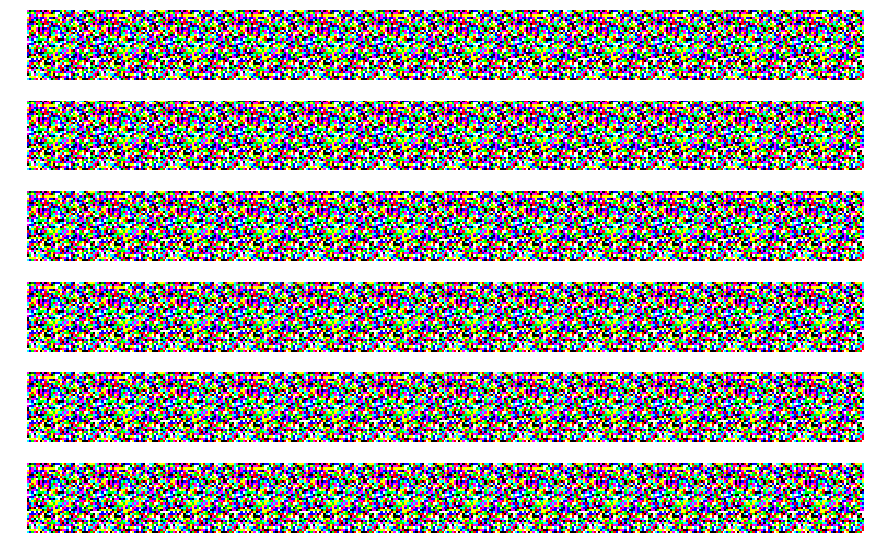

Epoch 3/111... Dloss: -28.5047 Gloss: -28.5047
Epoch 3/111... Dloss: -28.4502 Gloss: -28.4502
Epoch 3/111... Dloss: -28.5288 Gloss: -28.5288
Epoch 3/111... Dloss: -28.5064 Gloss: -28.5064
Epoch 3/111... Dloss: -28.5196 Gloss: -28.5196
Epoch 3/111... Dloss: -28.5518 Gloss: -28.5518
Epoch 3/111... Dloss: -28.4737 Gloss: -28.4737
Epoch 3/111... Dloss: -28.5458 Gloss: -28.5458
Epoch 3/111... Dloss: -28.5396 Gloss: -28.5396
Epoch 3/111... Dloss: -28.5147 Gloss: -28.5147


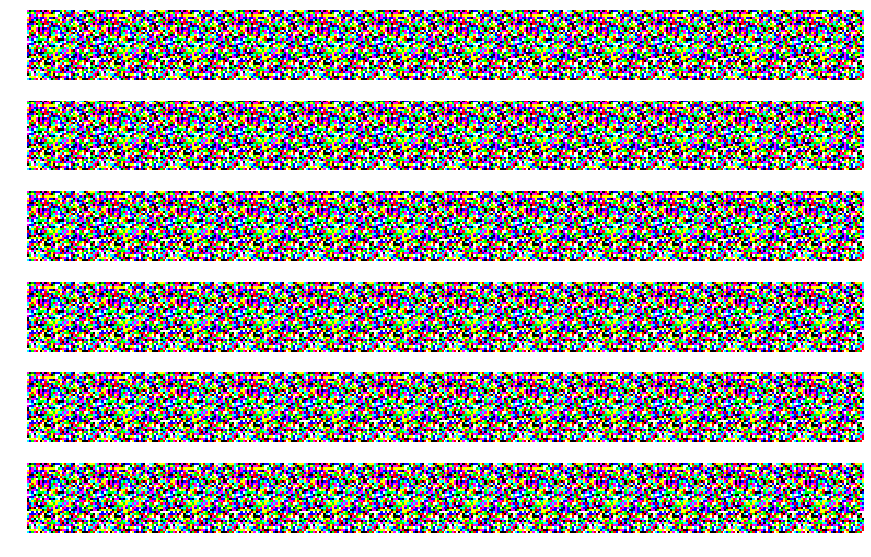

Epoch 3/111... Dloss: -28.5498 Gloss: -28.5498
Epoch 3/111... Dloss: -28.5037 Gloss: -28.5037
Epoch 3/111... Dloss: -28.5291 Gloss: -28.5291
Epoch 3/111... Dloss: -28.5564 Gloss: -28.5564
Epoch 3/111... Dloss: -28.5190 Gloss: -28.5190
Epoch 4/111... Dloss: -28.5274 Gloss: -28.5274
Epoch 4/111... Dloss: -28.5215 Gloss: -28.5215
Epoch 4/111... Dloss: -28.5433 Gloss: -28.5433
Epoch 4/111... Dloss: -28.5061 Gloss: -28.5061
Epoch 4/111... Dloss: -28.5143 Gloss: -28.5143


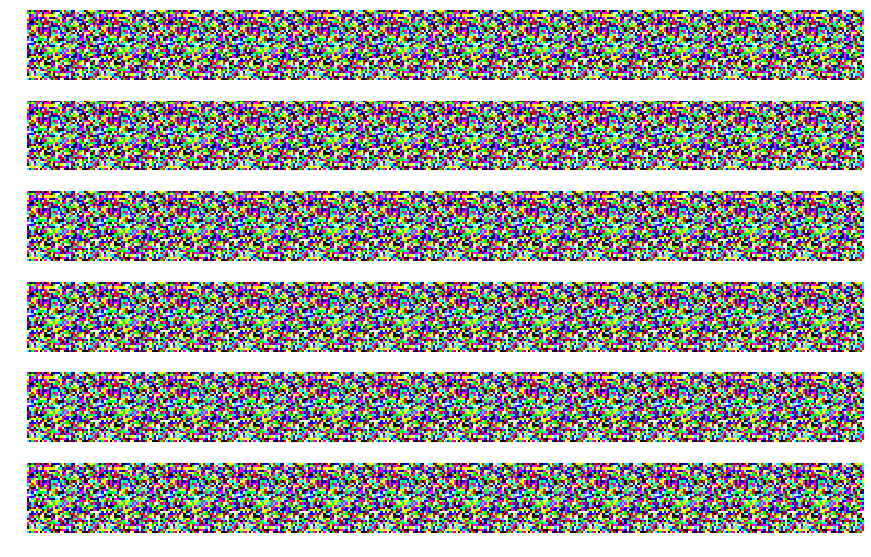

Epoch 4/111... Dloss: -28.5267 Gloss: -28.5267
Epoch 4/111... Dloss: -28.4712 Gloss: -28.4712
Epoch 4/111... Dloss: -28.5196 Gloss: -28.5196
Epoch 4/111... Dloss: -28.5136 Gloss: -28.5136
Epoch 4/111... Dloss: -28.5363 Gloss: -28.5363
Epoch 4/111... Dloss: -28.5314 Gloss: -28.5314
Epoch 4/111... Dloss: -28.5052 Gloss: -28.5052
Epoch 4/111... Dloss: -28.5138 Gloss: -28.5138
Epoch 4/111... Dloss: -28.5340 Gloss: -28.5340
Epoch 4/111... Dloss: -28.5074 Gloss: -28.5074


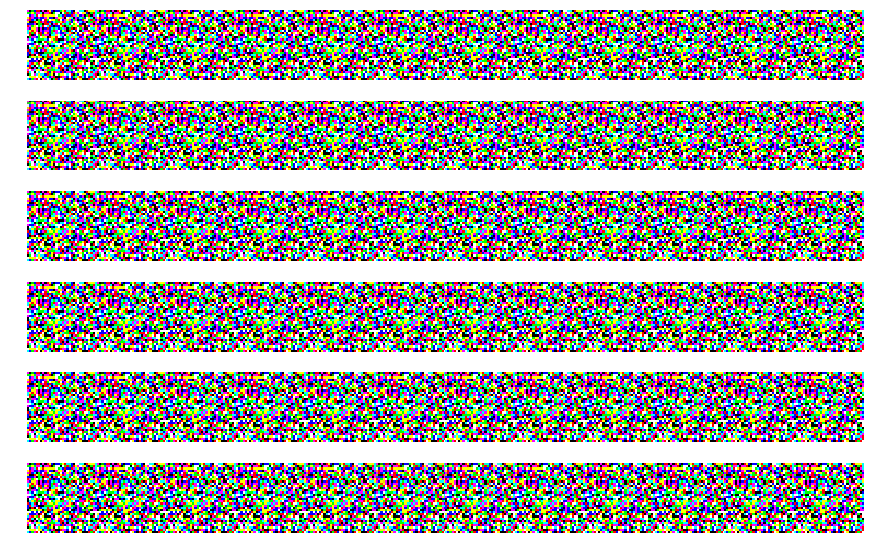

Epoch 4/111... Dloss: -28.5350 Gloss: -28.5350
Epoch 4/111... Dloss: -28.4888 Gloss: -28.4888
Epoch 4/111... Dloss: -28.5603 Gloss: -28.5603
Epoch 4/111... Dloss: -28.5414 Gloss: -28.5414
Epoch 4/111... Dloss: -28.5823 Gloss: -28.5823
Epoch 4/111... Dloss: -28.5242 Gloss: -28.5242
Epoch 4/111... Dloss: -28.5550 Gloss: -28.5550
Epoch 4/111... Dloss: -28.5393 Gloss: -28.5393
Epoch 4/111... Dloss: -28.5376 Gloss: -28.5376
Epoch 4/111... Dloss: -28.5131 Gloss: -28.5131


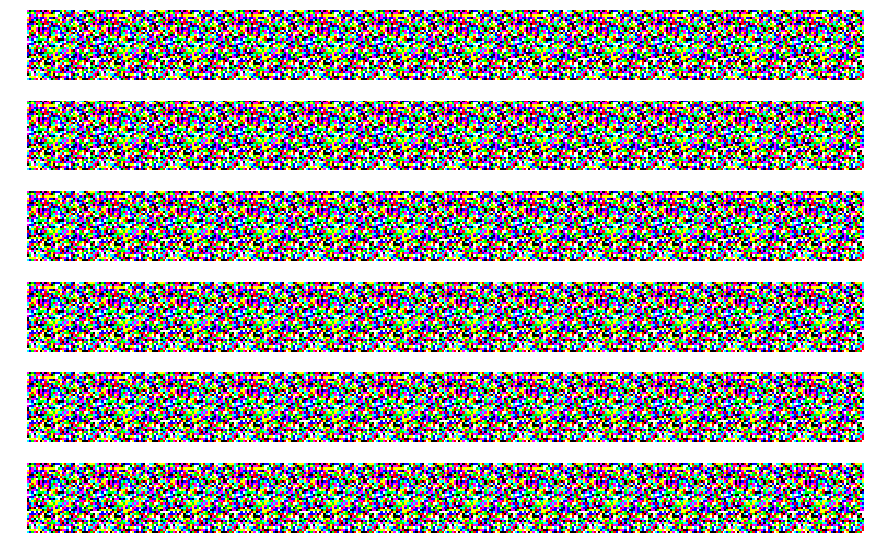

Epoch 4/111... Dloss: -28.5524 Gloss: -28.5524
Epoch 4/111... Dloss: -28.5102 Gloss: -28.5102
Epoch 4/111... Dloss: -28.5416 Gloss: -28.5416
Epoch 4/111... Dloss: -28.5689 Gloss: -28.5689
Epoch 5/111... Dloss: -28.5545 Gloss: -28.5545
Epoch 5/111... Dloss: -28.5512 Gloss: -28.5512
Epoch 5/111... Dloss: -28.5662 Gloss: -28.5662
Epoch 5/111... Dloss: -28.5333 Gloss: -28.5333
Epoch 5/111... Dloss: -28.5080 Gloss: -28.5080
Epoch 5/111... Dloss: -28.5498 Gloss: -28.5498


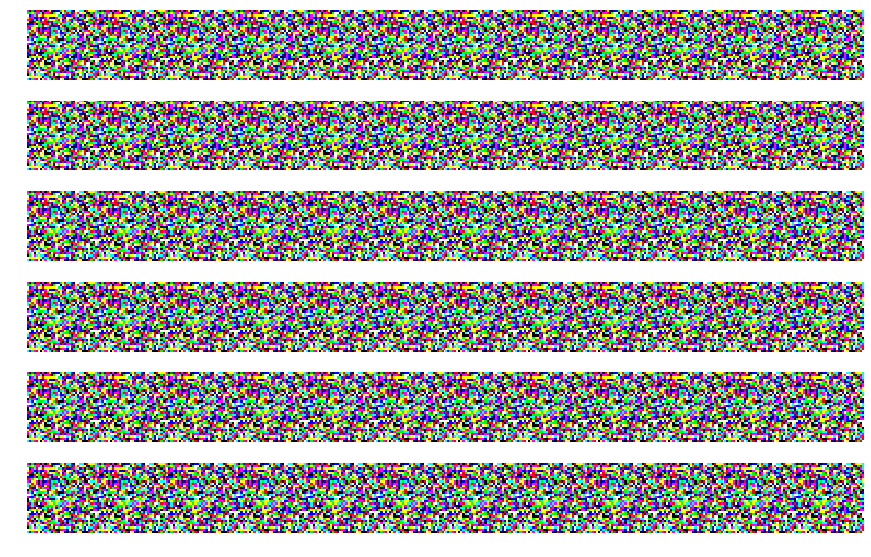

Epoch 5/111... Dloss: -28.5247 Gloss: -28.5247
Epoch 5/111... Dloss: -28.5340 Gloss: -28.5340
Epoch 5/111... Dloss: -28.5105 Gloss: -28.5105
Epoch 5/111... Dloss: -28.5447 Gloss: -28.5447
Epoch 5/111... Dloss: -28.5411 Gloss: -28.5411
Epoch 5/111... Dloss: -28.5234 Gloss: -28.5234
Epoch 5/111... Dloss: -28.5390 Gloss: -28.5390
Epoch 5/111... Dloss: -28.5223 Gloss: -28.5223
Epoch 5/111... Dloss: -28.5694 Gloss: -28.5694
Epoch 5/111... Dloss: -28.5446 Gloss: -28.5446


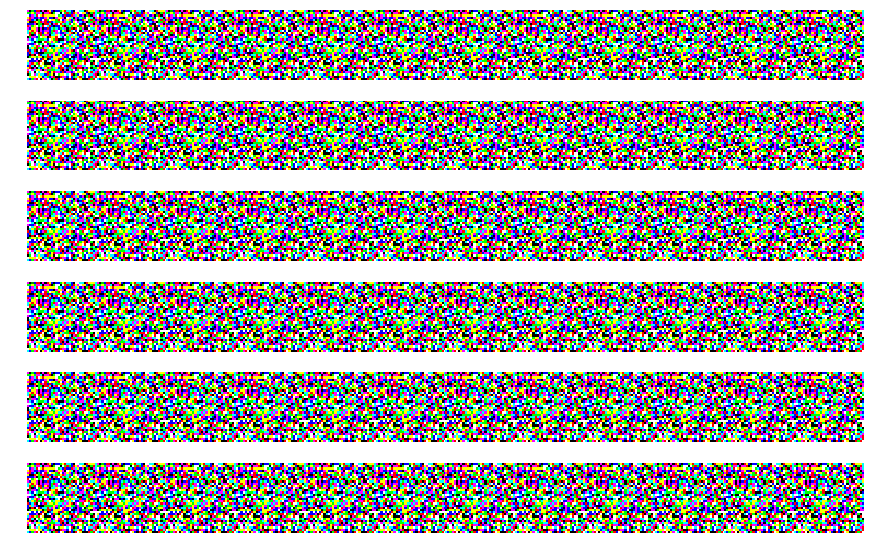

Epoch 5/111... Dloss: -28.5373 Gloss: -28.5373
Epoch 5/111... Dloss: -28.5276 Gloss: -28.5276
Epoch 5/111... Dloss: -28.5294 Gloss: -28.5294
Epoch 5/111... Dloss: -28.5099 Gloss: -28.5099
Epoch 5/111... Dloss: -28.5641 Gloss: -28.5641
Epoch 5/111... Dloss: -28.5735 Gloss: -28.5735
Epoch 5/111... Dloss: -28.5129 Gloss: -28.5129
Epoch 5/111... Dloss: -28.5145 Gloss: -28.5145
Epoch 5/111... Dloss: -28.5580 Gloss: -28.5580
Epoch 5/111... Dloss: -28.5593 Gloss: -28.5593


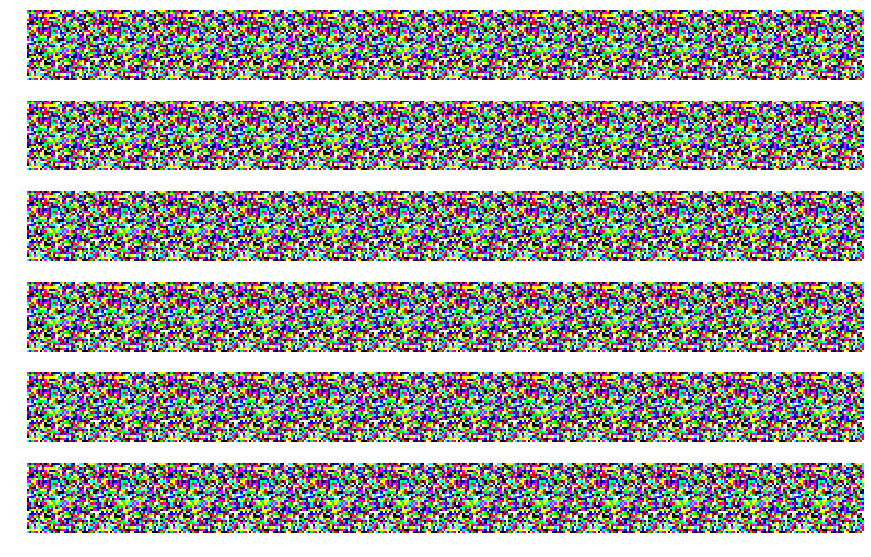

Epoch 5/111... Dloss: -28.5477 Gloss: -28.5477
Epoch 5/111... Dloss: -28.5335 Gloss: -28.5335
Epoch 5/111... Dloss: -28.5567 Gloss: -28.5567
Epoch 6/111... Dloss: -28.5263 Gloss: -28.5263
Epoch 6/111... Dloss: -28.5602 Gloss: -28.5602
Epoch 6/111... Dloss: -28.5204 Gloss: -28.5204
Epoch 6/111... Dloss: -28.5509 Gloss: -28.5509
Epoch 6/111... Dloss: -28.5491 Gloss: -28.5491
Epoch 6/111... Dloss: -28.5381 Gloss: -28.5381
Epoch 6/111... Dloss: -28.5187 Gloss: -28.5187


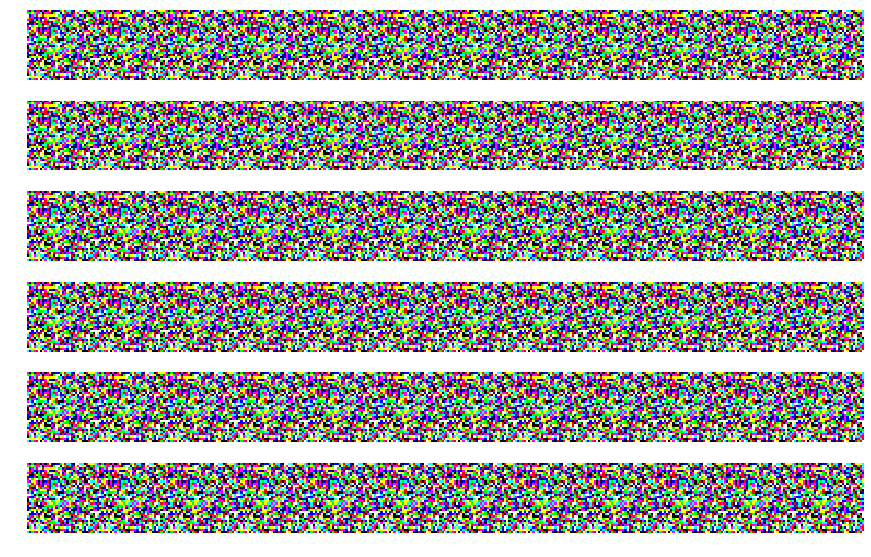

Epoch 6/111... Dloss: -28.5632 Gloss: -28.5632
Epoch 6/111... Dloss: -28.5842 Gloss: -28.5842
Epoch 6/111... Dloss: -28.5138 Gloss: -28.5138
Epoch 6/111... Dloss: -28.5355 Gloss: -28.5355
Epoch 6/111... Dloss: -28.5506 Gloss: -28.5506
Epoch 6/111... Dloss: -28.5371 Gloss: -28.5371
Epoch 6/111... Dloss: -28.5238 Gloss: -28.5238
Epoch 6/111... Dloss: -28.5542 Gloss: -28.5542
Epoch 6/111... Dloss: -28.5538 Gloss: -28.5538
Epoch 6/111... Dloss: -28.5611 Gloss: -28.5611


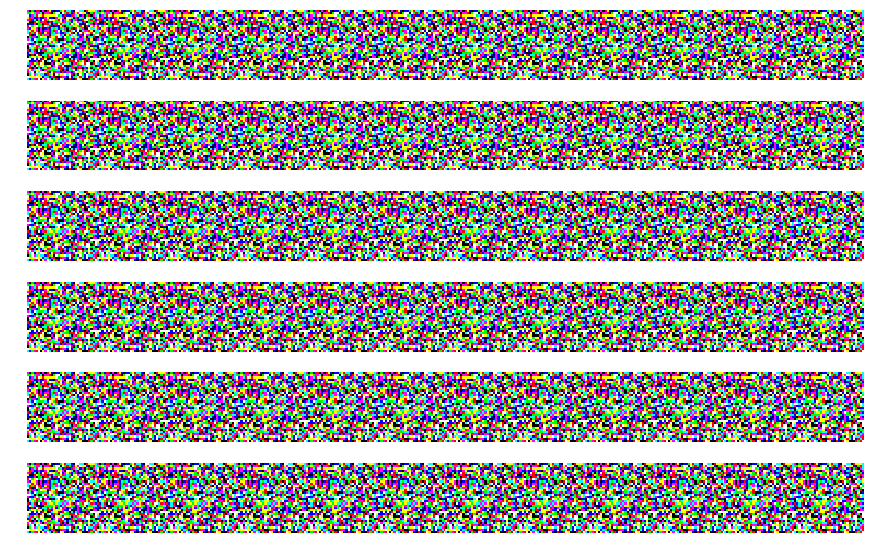

Epoch 6/111... Dloss: -28.5343 Gloss: -28.5343
Epoch 6/111... Dloss: -28.5497 Gloss: -28.5497
Epoch 6/111... Dloss: -28.5446 Gloss: -28.5446
Epoch 6/111... Dloss: -28.5548 Gloss: -28.5548
Epoch 6/111... Dloss: -28.5608 Gloss: -28.5608
Epoch 6/111... Dloss: -28.5525 Gloss: -28.5525
Epoch 6/111... Dloss: -28.5609 Gloss: -28.5609
Epoch 6/111... Dloss: -28.5389 Gloss: -28.5389
Epoch 6/111... Dloss: -28.5678 Gloss: -28.5678
Epoch 6/111... Dloss: -28.5354 Gloss: -28.5354


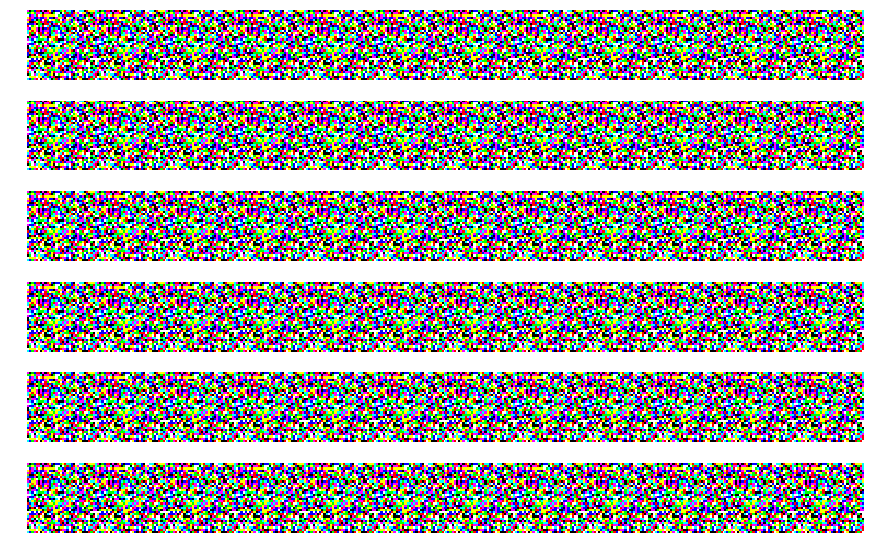

Epoch 6/111... Dloss: -28.5474 Gloss: -28.5474
Epoch 7/111... Dloss: -28.5247 Gloss: -28.5247
Epoch 7/111... Dloss: -28.5363 Gloss: -28.5363
Epoch 7/111... Dloss: -28.5506 Gloss: -28.5506
Epoch 7/111... Dloss: -28.5587 Gloss: -28.5587
Epoch 7/111... Dloss: -28.5325 Gloss: -28.5325
Epoch 7/111... Dloss: -28.5647 Gloss: -28.5647
Epoch 7/111... Dloss: -28.5161 Gloss: -28.5161
Epoch 7/111... Dloss: -28.5330 Gloss: -28.5330
Epoch 7/111... Dloss: -28.5085 Gloss: -28.5085


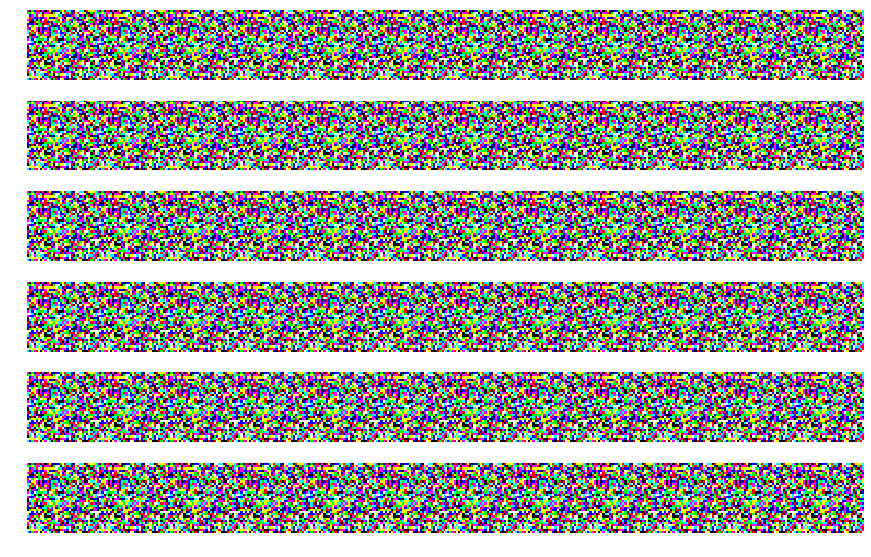

Epoch 7/111... Dloss: -28.5635 Gloss: -28.5635
Epoch 7/111... Dloss: -28.5287 Gloss: -28.5287
Epoch 7/111... Dloss: -28.5299 Gloss: -28.5299
Epoch 7/111... Dloss: -28.5139 Gloss: -28.5139
Epoch 7/111... Dloss: -28.5294 Gloss: -28.5294
Epoch 7/111... Dloss: -28.5178 Gloss: -28.5178
Epoch 7/111... Dloss: -28.5008 Gloss: -28.5008
Epoch 7/111... Dloss: -28.5534 Gloss: -28.5534
Epoch 7/111... Dloss: -28.5582 Gloss: -28.5582
Epoch 7/111... Dloss: -28.5092 Gloss: -28.5092


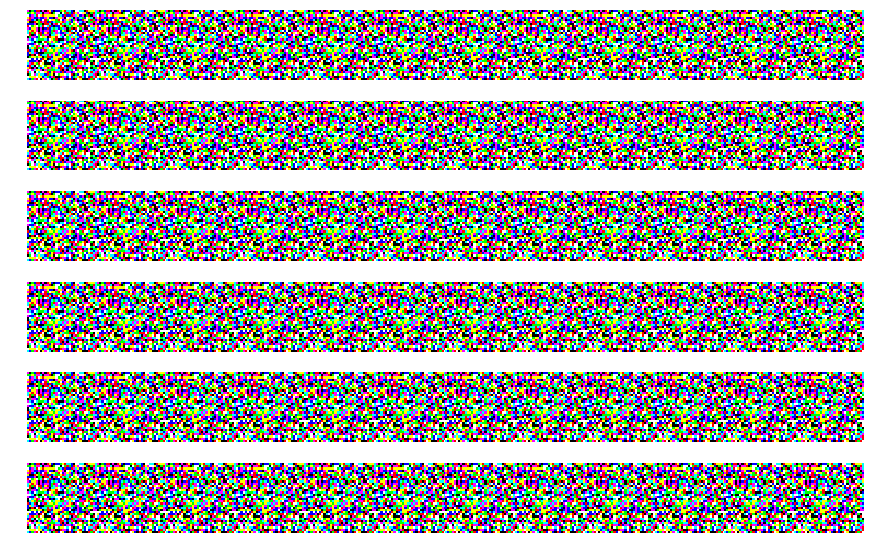

Epoch 7/111... Dloss: -28.5316 Gloss: -28.5316
Epoch 7/111... Dloss: -28.5383 Gloss: -28.5384
Epoch 7/111... Dloss: -28.5409 Gloss: -28.5409
Epoch 7/111... Dloss: -28.5471 Gloss: -28.5471
Epoch 7/111... Dloss: -28.5686 Gloss: -28.5686
Epoch 7/111... Dloss: -28.5091 Gloss: -28.5091
Epoch 7/111... Dloss: -28.5262 Gloss: -28.5262
Epoch 7/111... Dloss: -28.5478 Gloss: -28.5478
Epoch 7/111... Dloss: -28.4962 Gloss: -28.4962
Epoch 7/111... Dloss: -28.5724 Gloss: -28.5724


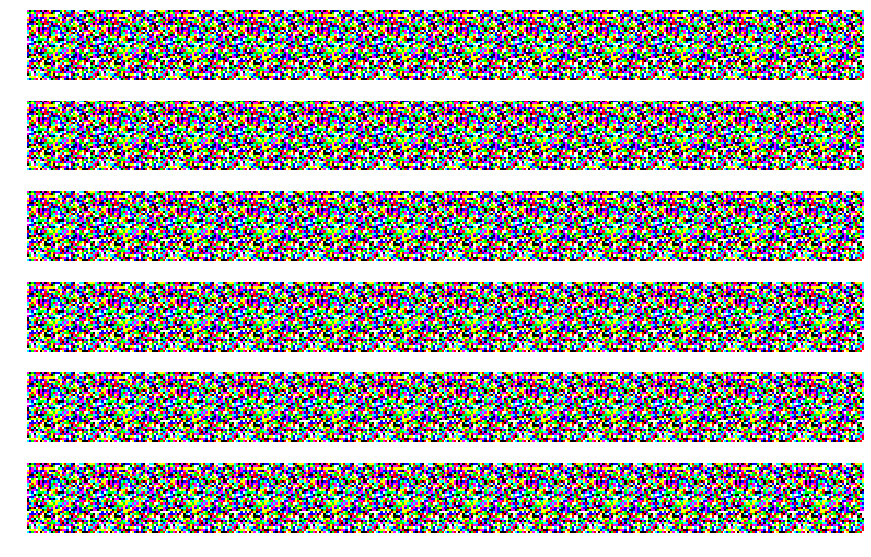

Epoch 8/111... Dloss: -28.5347 Gloss: -28.5347
Epoch 8/111... Dloss: -28.5422 Gloss: -28.5422
Epoch 8/111... Dloss: -28.5432 Gloss: -28.5432
Epoch 8/111... Dloss: -28.5183 Gloss: -28.5183
Epoch 8/111... Dloss: -28.5567 Gloss: -28.5567
Epoch 8/111... Dloss: -28.5416 Gloss: -28.5416
Epoch 8/111... Dloss: -28.5535 Gloss: -28.5535
Epoch 8/111... Dloss: -28.5656 Gloss: -28.5656
Epoch 8/111... Dloss: -28.5367 Gloss: -28.5367
Epoch 8/111... Dloss: -28.5660 Gloss: -28.5660


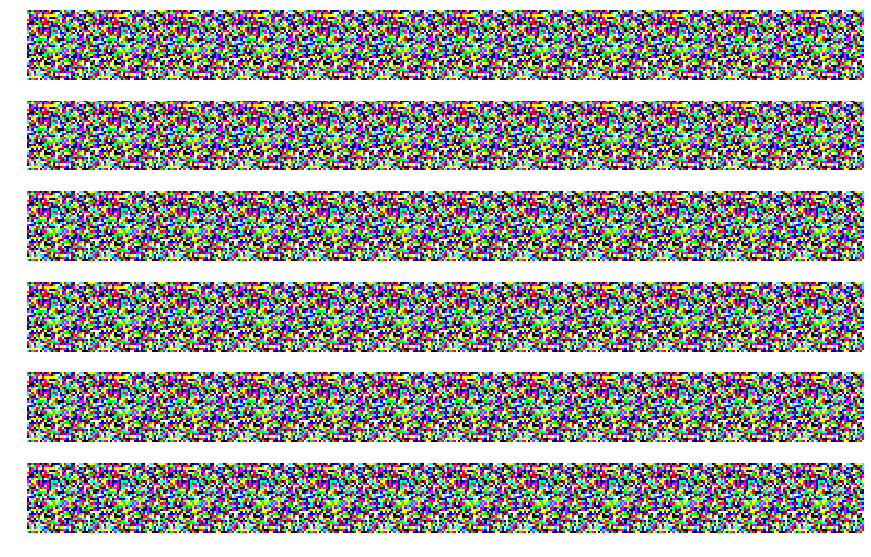

Epoch 8/111... Dloss: -28.5522 Gloss: -28.5522
Epoch 8/111... Dloss: -28.5384 Gloss: -28.5384
Epoch 8/111... Dloss: -28.5102 Gloss: -28.5102
Epoch 8/111... Dloss: -28.5103 Gloss: -28.5103
Epoch 8/111... Dloss: -28.5095 Gloss: -28.5095
Epoch 8/111... Dloss: -28.5876 Gloss: -28.5876
Epoch 8/111... Dloss: -28.5668 Gloss: -28.5668
Epoch 8/111... Dloss: -28.5209 Gloss: -28.5209
Epoch 8/111... Dloss: -28.5269 Gloss: -28.5269
Epoch 8/111... Dloss: -28.5545 Gloss: -28.5545


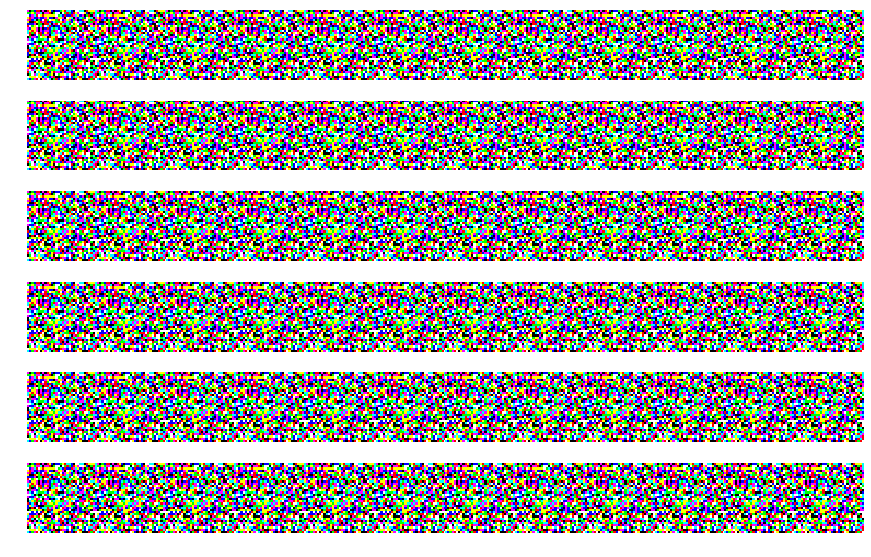

Epoch 8/111... Dloss: -28.5452 Gloss: -28.5452
Epoch 8/111... Dloss: -28.5562 Gloss: -28.5562
Epoch 8/111... Dloss: -28.5425 Gloss: -28.5425
Epoch 8/111... Dloss: -28.5397 Gloss: -28.5397
Epoch 8/111... Dloss: -28.5578 Gloss: -28.5578
Epoch 8/111... Dloss: -28.5162 Gloss: -28.5162
Epoch 8/111... Dloss: -28.5696 Gloss: -28.5696
Epoch 8/111... Dloss: -28.5398 Gloss: -28.5398
Epoch 8/111... Dloss: -28.5247 Gloss: -28.5247
Epoch 9/111... Dloss: -28.5500 Gloss: -28.5500


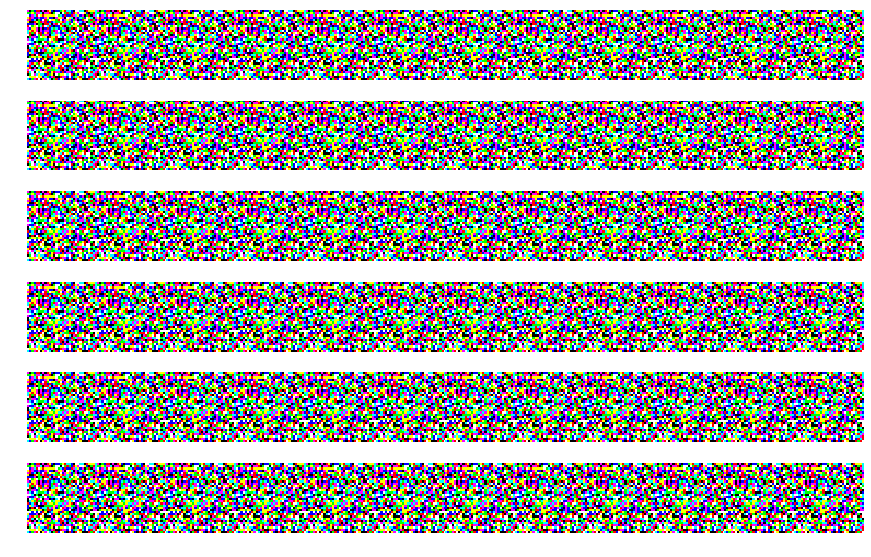

Epoch 9/111... Dloss: -28.5508 Gloss: -28.5508
Epoch 9/111... Dloss: -28.5394 Gloss: -28.5394
Epoch 9/111... Dloss: -28.5494 Gloss: -28.5494
Epoch 9/111... Dloss: -28.5251 Gloss: -28.5251
Epoch 9/111... Dloss: -28.5394 Gloss: -28.5394
Epoch 9/111... Dloss: -28.5164 Gloss: -28.5164
Epoch 9/111... Dloss: -28.5623 Gloss: -28.5623
Epoch 9/111... Dloss: -28.5418 Gloss: -28.5418
Epoch 9/111... Dloss: -28.5669 Gloss: -28.5669
Epoch 9/111... Dloss: -28.5492 Gloss: -28.5492


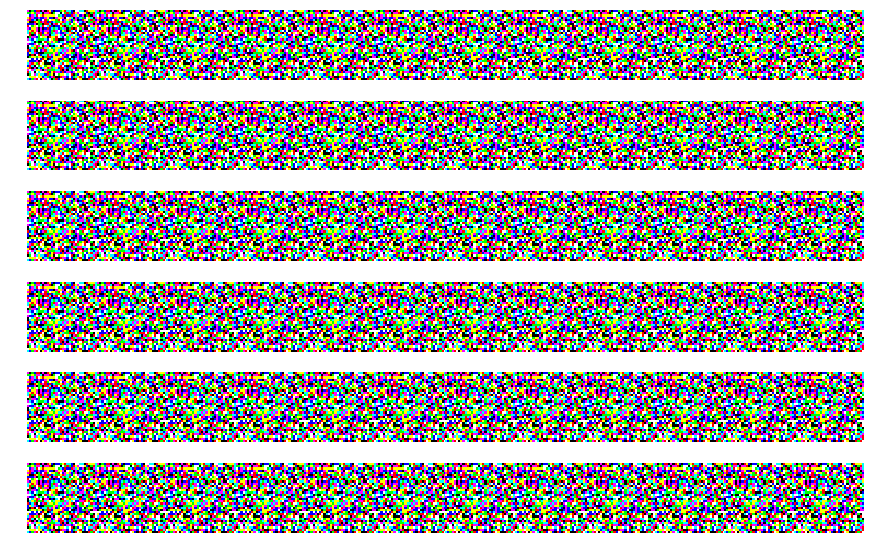

Epoch 9/111... Dloss: -28.5588 Gloss: -28.5588
Epoch 9/111... Dloss: -28.5174 Gloss: -28.5174
Epoch 9/111... Dloss: -28.5378 Gloss: -28.5378
Epoch 9/111... Dloss: -28.5535 Gloss: -28.5535
Epoch 9/111... Dloss: -28.5503 Gloss: -28.5503
Epoch 9/111... Dloss: -28.5562 Gloss: -28.5562
Epoch 9/111... Dloss: -28.5504 Gloss: -28.5504
Epoch 9/111... Dloss: -28.5537 Gloss: -28.5537
Epoch 9/111... Dloss: -28.5511 Gloss: -28.5511
Epoch 9/111... Dloss: -28.5369 Gloss: -28.5369


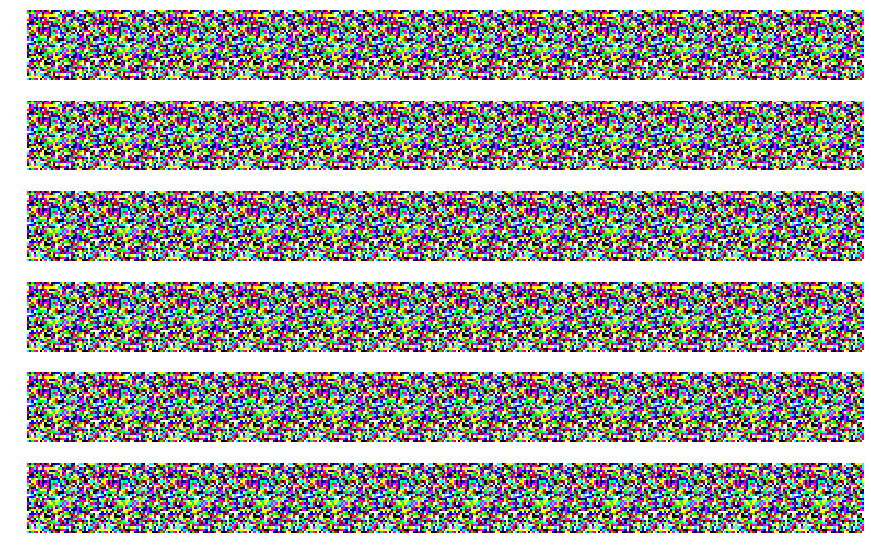

Epoch 9/111... Dloss: -28.5403 Gloss: -28.5403
Epoch 9/111... Dloss: -28.5449 Gloss: -28.5449
Epoch 9/111... Dloss: -28.5624 Gloss: -28.5624
Epoch 9/111... Dloss: -28.5467 Gloss: -28.5467
Epoch 9/111... Dloss: -28.5520 Gloss: -28.5520
Epoch 9/111... Dloss: -28.5493 Gloss: -28.5493
Epoch 9/111... Dloss: -28.5712 Gloss: -28.5712
Epoch 10/111... Dloss: -28.5686 Gloss: -28.5686
Epoch 10/111... Dloss: -28.5199 Gloss: -28.5199
Epoch 10/111... Dloss: -28.5353 Gloss: -28.5353


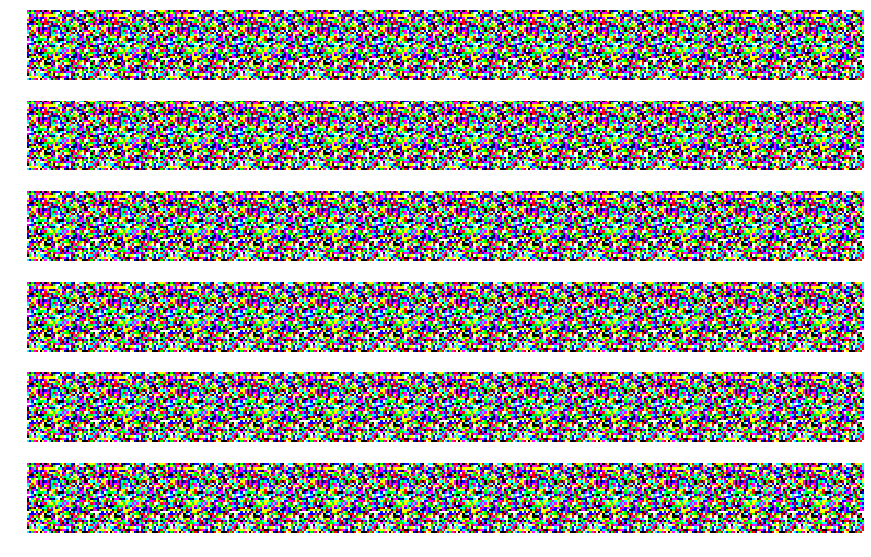

Epoch 10/111... Dloss: -28.5833 Gloss: -28.5833
Epoch 10/111... Dloss: -28.5427 Gloss: -28.5427
Epoch 10/111... Dloss: -28.5545 Gloss: -28.5545
Epoch 10/111... Dloss: -28.5459 Gloss: -28.5459
Epoch 10/111... Dloss: -28.5405 Gloss: -28.5405
Epoch 10/111... Dloss: -28.5461 Gloss: -28.5461
Epoch 10/111... Dloss: -28.5816 Gloss: -28.5816
Epoch 10/111... Dloss: -28.5202 Gloss: -28.5202
Epoch 10/111... Dloss: -28.5133 Gloss: -28.5133
Epoch 10/111... Dloss: -28.5194 Gloss: -28.5194


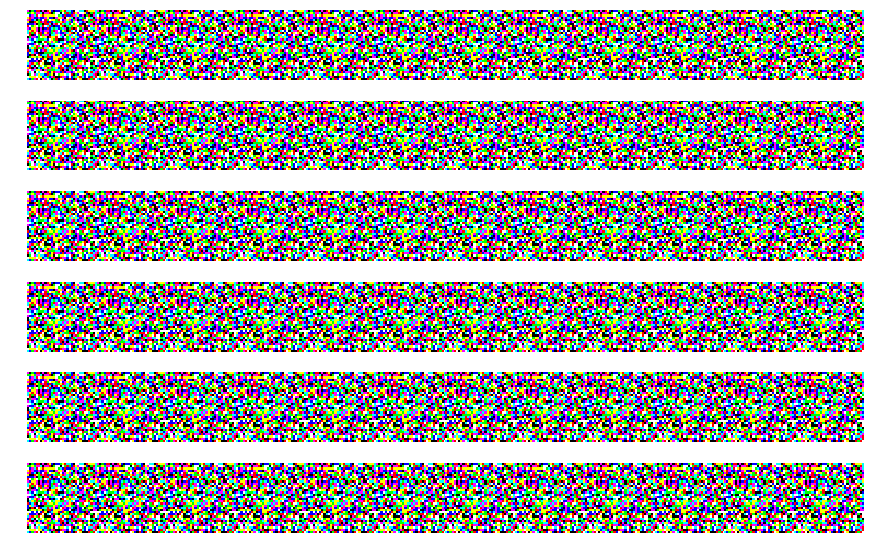

Epoch 10/111... Dloss: -28.5285 Gloss: -28.5285
Epoch 10/111... Dloss: -28.5225 Gloss: -28.5225
Epoch 10/111... Dloss: -28.5592 Gloss: -28.5592
Epoch 10/111... Dloss: -28.5924 Gloss: -28.5924
Epoch 10/111... Dloss: -28.5630 Gloss: -28.5630
Epoch 10/111... Dloss: -28.5264 Gloss: -28.5264
Epoch 10/111... Dloss: -28.5525 Gloss: -28.5525
Epoch 10/111... Dloss: -28.5647 Gloss: -28.5647
Epoch 10/111... Dloss: -28.5319 Gloss: -28.5319
Epoch 10/111... Dloss: -28.5459 Gloss: -28.5459


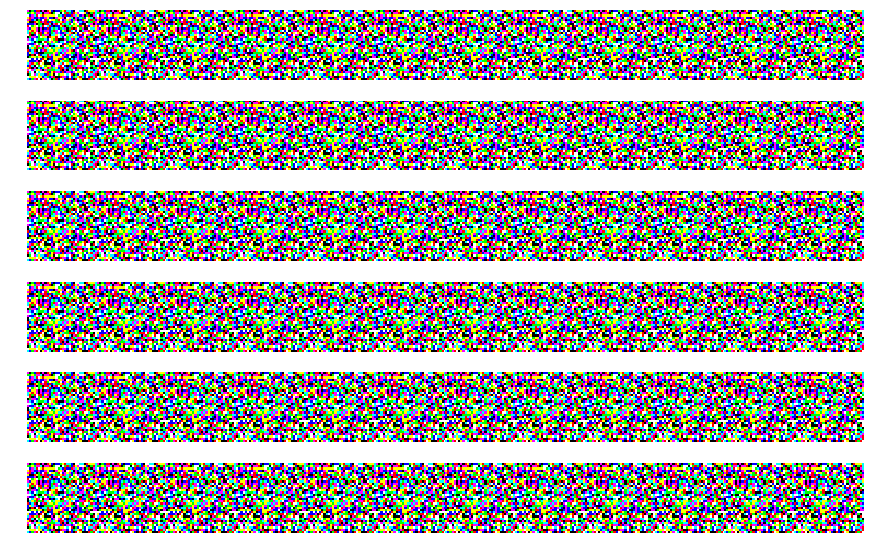

Epoch 10/111... Dloss: -28.5703 Gloss: -28.5703
Epoch 10/111... Dloss: -28.5530 Gloss: -28.5530
Epoch 10/111... Dloss: -28.5593 Gloss: -28.5593
Epoch 10/111... Dloss: -28.5482 Gloss: -28.5482
Epoch 10/111... Dloss: -28.4994 Gloss: -28.4994
Epoch 10/111... Dloss: -28.5568 Gloss: -28.5568
Epoch 11/111... Dloss: -28.5079 Gloss: -28.5079
Epoch 11/111... Dloss: -28.5518 Gloss: -28.5518
Epoch 11/111... Dloss: -28.5305 Gloss: -28.5305
Epoch 11/111... Dloss: -28.5393 Gloss: -28.5393


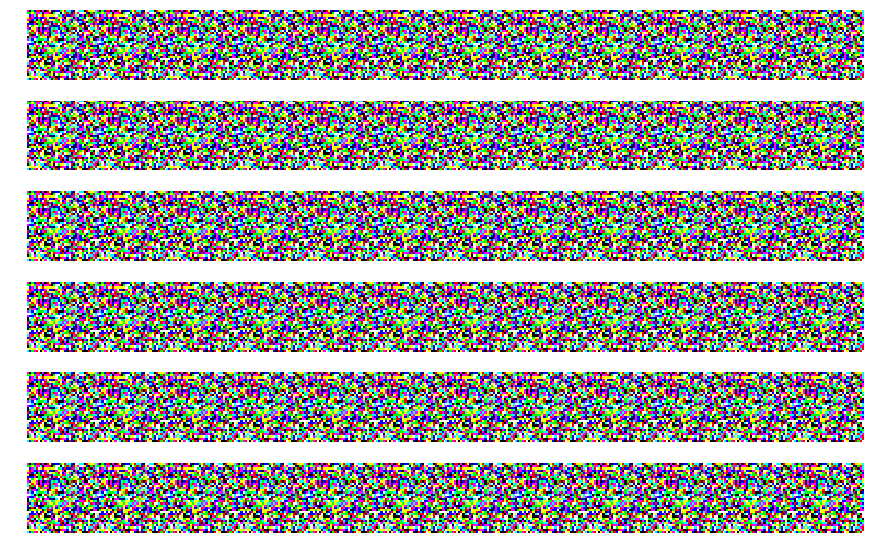

Epoch 11/111... Dloss: -28.5320 Gloss: -28.5320
Epoch 11/111... Dloss: -28.5431 Gloss: -28.5431
Epoch 11/111... Dloss: -28.5420 Gloss: -28.5420
Epoch 11/111... Dloss: -28.5233 Gloss: -28.5233
Epoch 11/111... Dloss: -28.5318 Gloss: -28.5318
Epoch 11/111... Dloss: -28.5314 Gloss: -28.5314
Epoch 11/111... Dloss: -28.5276 Gloss: -28.5276
Epoch 11/111... Dloss: -28.5587 Gloss: -28.5587
Epoch 11/111... Dloss: -28.5181 Gloss: -28.5181
Epoch 11/111... Dloss: -28.5310 Gloss: -28.5310


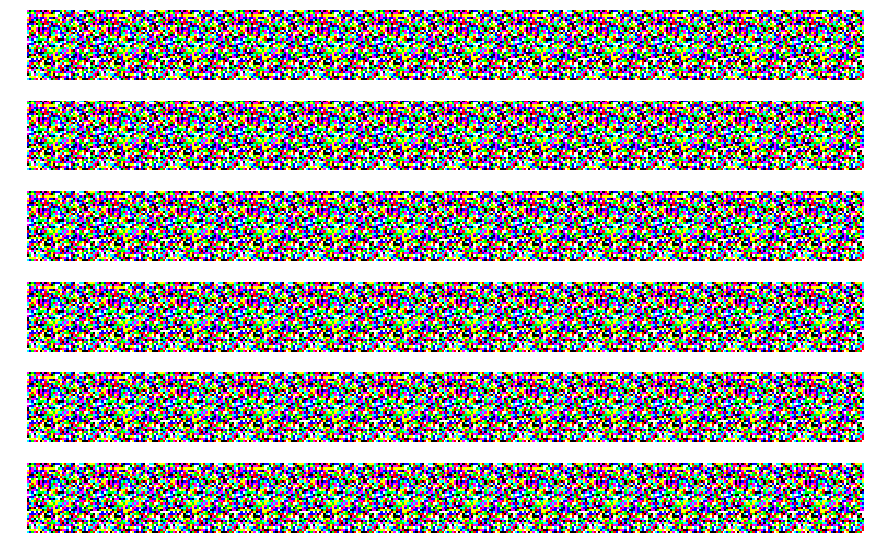

Epoch 11/111... Dloss: -28.5438 Gloss: -28.5438
Epoch 11/111... Dloss: -28.5302 Gloss: -28.5302
Epoch 11/111... Dloss: -28.5384 Gloss: -28.5384
Epoch 11/111... Dloss: -28.5270 Gloss: -28.5270
Epoch 11/111... Dloss: -28.5451 Gloss: -28.5451
Epoch 11/111... Dloss: -28.5162 Gloss: -28.5162
Epoch 11/111... Dloss: -28.5542 Gloss: -28.5542
Epoch 11/111... Dloss: -28.5584 Gloss: -28.5584
Epoch 11/111... Dloss: -28.5487 Gloss: -28.5487
Epoch 11/111... Dloss: -28.5064 Gloss: -28.5064


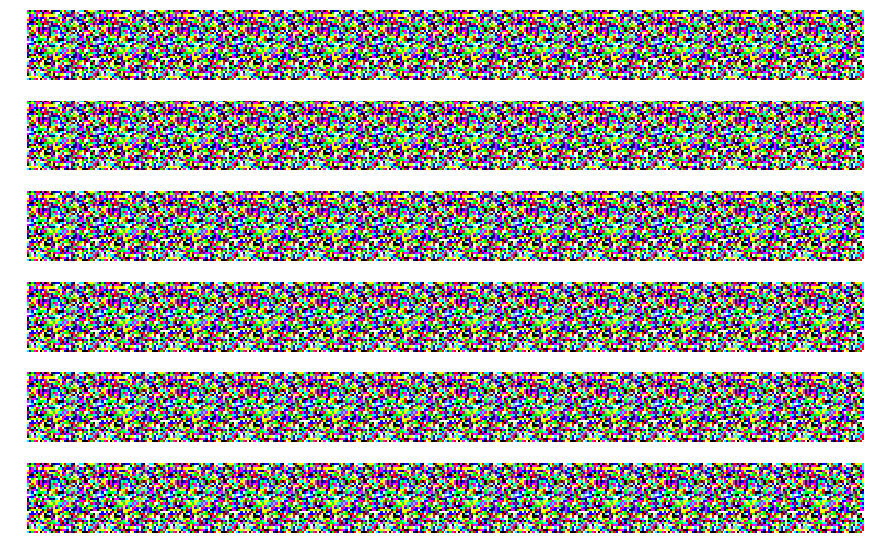

Epoch 11/111... Dloss: -28.5494 Gloss: -28.5494
Epoch 11/111... Dloss: -28.5478 Gloss: -28.5478
Epoch 11/111... Dloss: -28.5564 Gloss: -28.5564
Epoch 11/111... Dloss: -28.5642 Gloss: -28.5642
Epoch 11/111... Dloss: -28.5493 Gloss: -28.5493
Epoch 12/111... Dloss: -28.5658 Gloss: -28.5658
Epoch 12/111... Dloss: -28.5480 Gloss: -28.5480
Epoch 12/111... Dloss: -28.5437 Gloss: -28.5437
Epoch 12/111... Dloss: -28.5563 Gloss: -28.5563
Epoch 12/111... Dloss: -28.5564 Gloss: -28.5564


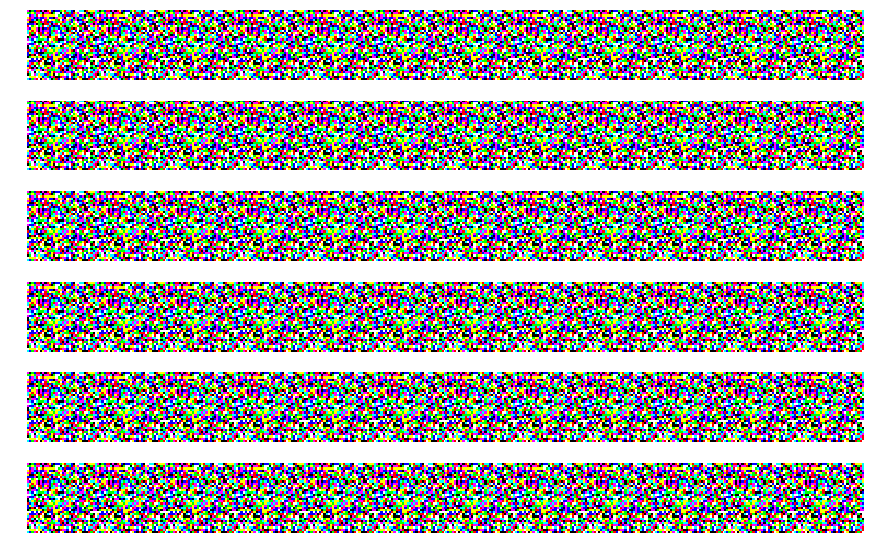

Epoch 12/111... Dloss: -28.5686 Gloss: -28.5686
Epoch 12/111... Dloss: -28.5488 Gloss: -28.5488
Epoch 12/111... Dloss: -28.5085 Gloss: -28.5085
Epoch 12/111... Dloss: -28.5707 Gloss: -28.5707
Epoch 12/111... Dloss: -28.5348 Gloss: -28.5348
Epoch 12/111... Dloss: -28.5362 Gloss: -28.5362
Epoch 12/111... Dloss: -28.5453 Gloss: -28.5453
Epoch 12/111... Dloss: -28.5041 Gloss: -28.5041
Epoch 12/111... Dloss: -28.5342 Gloss: -28.5342
Epoch 12/111... Dloss: -28.5429 Gloss: -28.5429


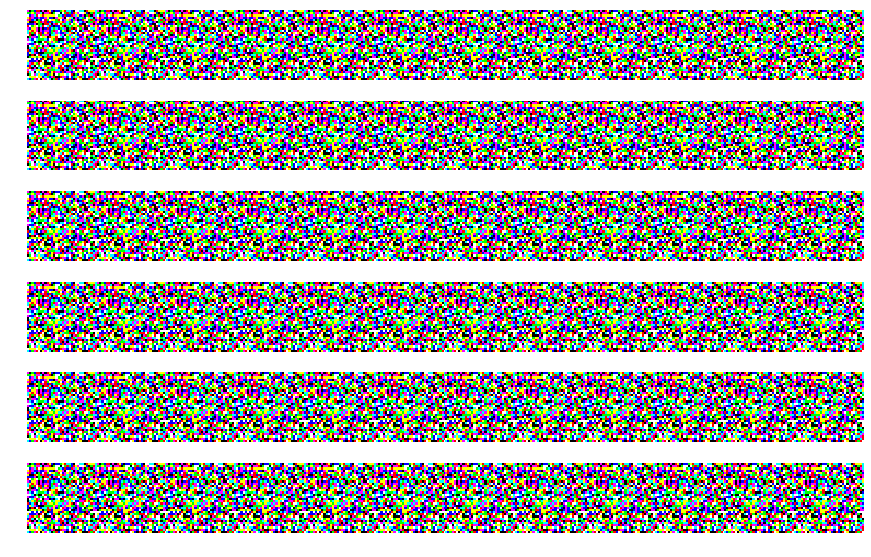

Epoch 12/111... Dloss: -28.5257 Gloss: -28.5257
Epoch 12/111... Dloss: -28.5593 Gloss: -28.5593
Epoch 12/111... Dloss: -28.5253 Gloss: -28.5253
Epoch 12/111... Dloss: -28.5594 Gloss: -28.5594
Epoch 12/111... Dloss: -28.5244 Gloss: -28.5244
Epoch 12/111... Dloss: -28.5274 Gloss: -28.5274
Epoch 12/111... Dloss: -28.5421 Gloss: -28.5421
Epoch 12/111... Dloss: -28.5161 Gloss: -28.5161
Epoch 12/111... Dloss: -28.5399 Gloss: -28.5399
Epoch 12/111... Dloss: -28.5358 Gloss: -28.5358


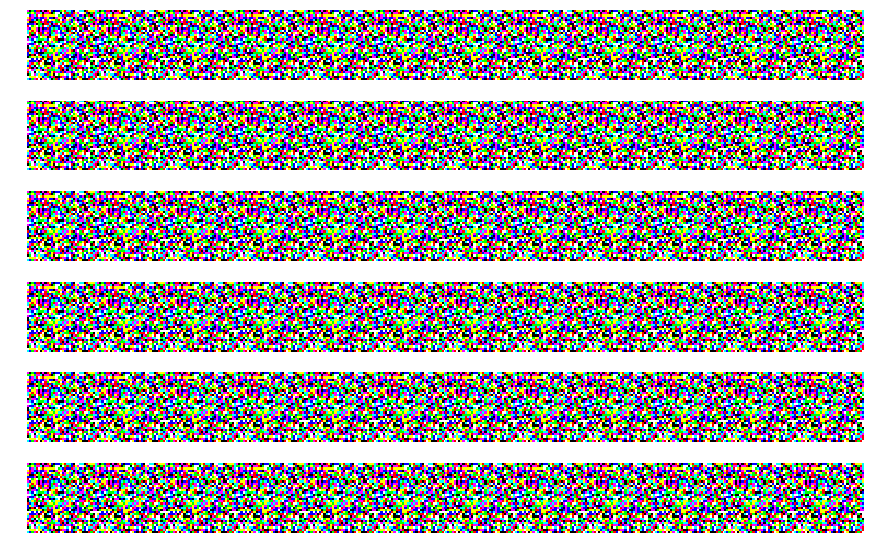

Epoch 12/111... Dloss: -28.5661 Gloss: -28.5661
Epoch 12/111... Dloss: -28.5295 Gloss: -28.5295
Epoch 12/111... Dloss: -28.5237 Gloss: -28.5237
Epoch 13/111... Dloss: -28.5037 Gloss: -28.5037
Epoch 13/111... Dloss: -28.5235 Gloss: -28.5235
Epoch 13/111... Dloss: -28.5322 Gloss: -28.5322
Epoch 13/111... Dloss: -28.5630 Gloss: -28.5630
Epoch 13/111... Dloss: -28.5143 Gloss: -28.5143
Epoch 13/111... Dloss: -28.5211 Gloss: -28.5211
Epoch 13/111... Dloss: -28.5460 Gloss: -28.5460


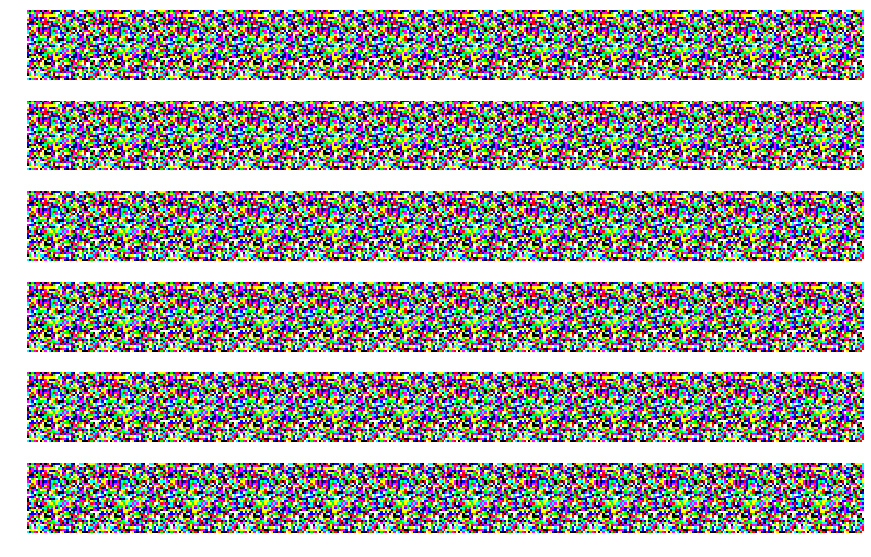

Epoch 13/111... Dloss: -28.5602 Gloss: -28.5602
Epoch 13/111... Dloss: -28.5143 Gloss: -28.5143
Epoch 13/111... Dloss: -28.5542 Gloss: -28.5542
Epoch 13/111... Dloss: -28.5366 Gloss: -28.5366
Epoch 13/111... Dloss: -28.5548 Gloss: -28.5548
Epoch 13/111... Dloss: -28.5573 Gloss: -28.5573
Epoch 13/111... Dloss: -28.5492 Gloss: -28.5492
Epoch 13/111... Dloss: -28.5526 Gloss: -28.5526
Epoch 13/111... Dloss: -28.5369 Gloss: -28.5369
Epoch 13/111... Dloss: -28.5469 Gloss: -28.5469


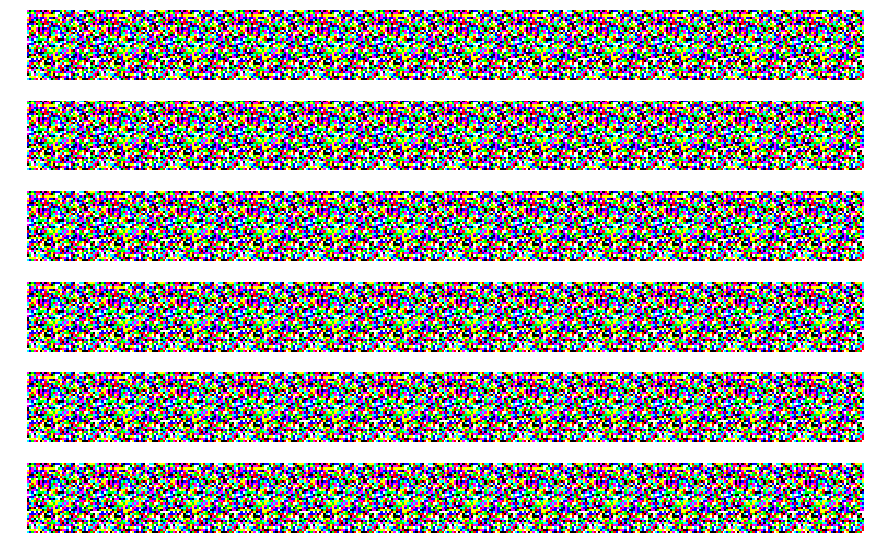

Epoch 13/111... Dloss: -28.5543 Gloss: -28.5543
Epoch 13/111... Dloss: -28.5402 Gloss: -28.5402
Epoch 13/111... Dloss: -28.5309 Gloss: -28.5309
Epoch 13/111... Dloss: -28.5555 Gloss: -28.5555
Epoch 13/111... Dloss: -28.5423 Gloss: -28.5423
Epoch 13/111... Dloss: -28.5140 Gloss: -28.5140
Epoch 13/111... Dloss: -28.5254 Gloss: -28.5254
Epoch 13/111... Dloss: -28.5913 Gloss: -28.5913
Epoch 13/111... Dloss: -28.5008 Gloss: -28.5008
Epoch 13/111... Dloss: -28.5308 Gloss: -28.5308


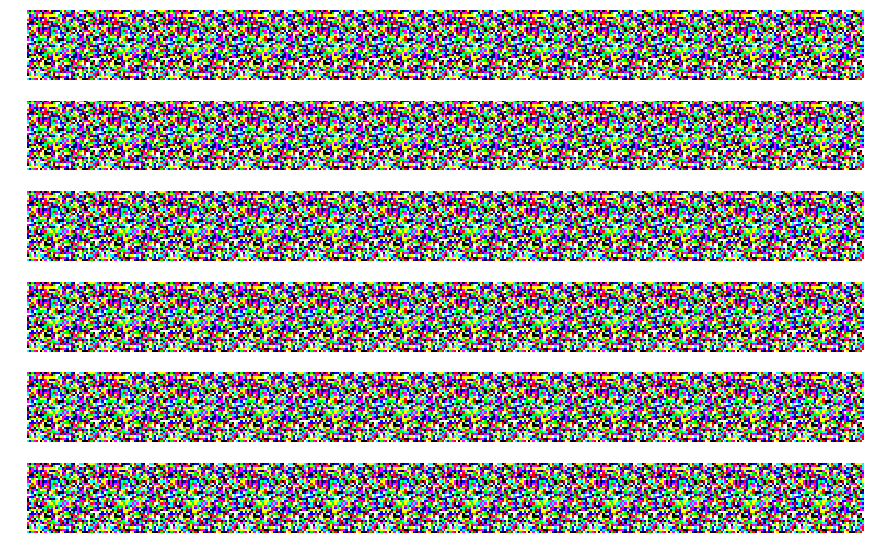

Epoch 13/111... Dloss: -28.5261 Gloss: -28.5261
Epoch 13/111... Dloss: -28.5596 Gloss: -28.5596
Epoch 14/111... Dloss: -28.5508 Gloss: -28.5508
Epoch 14/111... Dloss: -28.5682 Gloss: -28.5682
Epoch 14/111... Dloss: -28.5527 Gloss: -28.5527
Epoch 14/111... Dloss: -28.5912 Gloss: -28.5912
Epoch 14/111... Dloss: -28.5673 Gloss: -28.5673
Epoch 14/111... Dloss: -28.5070 Gloss: -28.5070
Epoch 14/111... Dloss: -28.5485 Gloss: -28.5485
Epoch 14/111... Dloss: -28.5928 Gloss: -28.5928


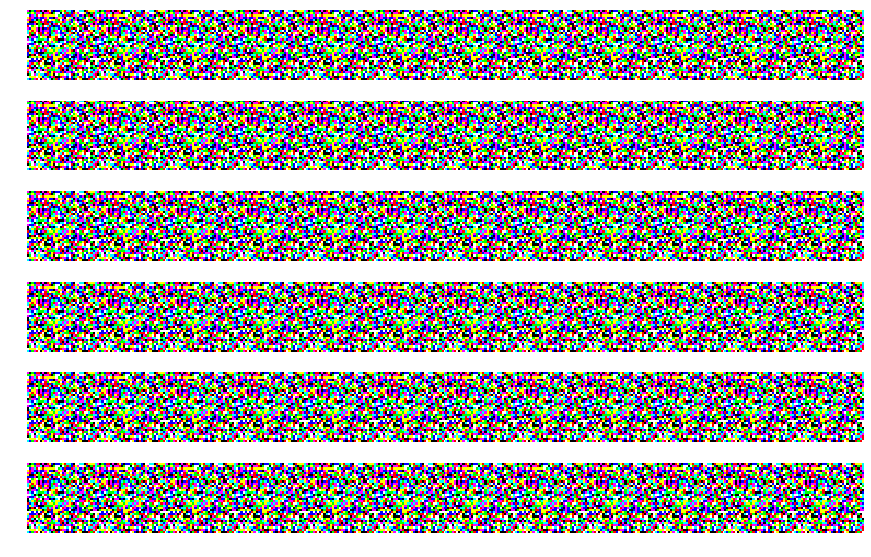

Epoch 14/111... Dloss: -28.5577 Gloss: -28.5577
Epoch 14/111... Dloss: -28.5440 Gloss: -28.5440
Epoch 14/111... Dloss: -28.5360 Gloss: -28.5360
Epoch 14/111... Dloss: -28.5803 Gloss: -28.5803
Epoch 14/111... Dloss: -28.5579 Gloss: -28.5579
Epoch 14/111... Dloss: -28.5691 Gloss: -28.5691
Epoch 14/111... Dloss: -28.5345 Gloss: -28.5345
Epoch 14/111... Dloss: -28.5474 Gloss: -28.5474
Epoch 14/111... Dloss: -28.5150 Gloss: -28.5150
Epoch 14/111... Dloss: -28.5624 Gloss: -28.5624


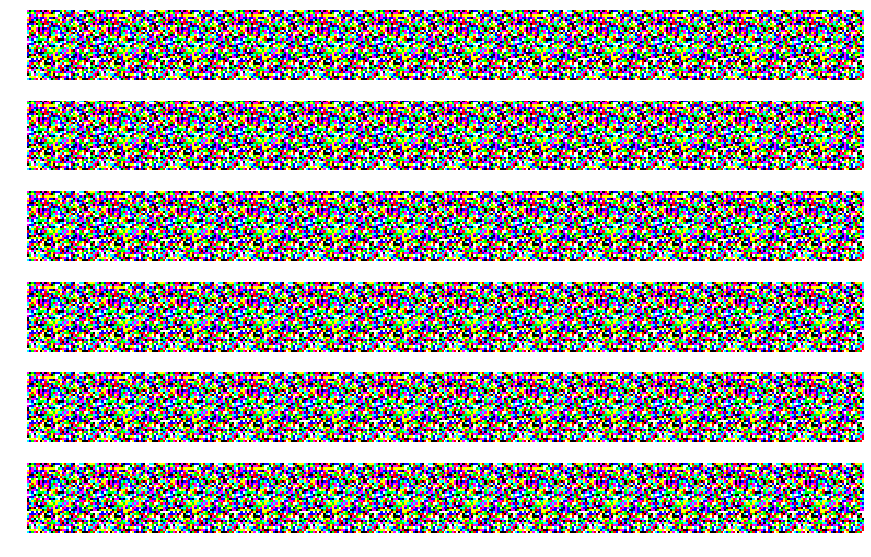

Epoch 14/111... Dloss: -28.5667 Gloss: -28.5667
Epoch 14/111... Dloss: -28.5481 Gloss: -28.5481
Epoch 14/111... Dloss: -28.5215 Gloss: -28.5215
Epoch 14/111... Dloss: -28.5429 Gloss: -28.5429
Epoch 14/111... Dloss: -28.5184 Gloss: -28.5184
Epoch 14/111... Dloss: -28.5263 Gloss: -28.5263
Epoch 14/111... Dloss: -28.5420 Gloss: -28.5420
Epoch 14/111... Dloss: -28.5401 Gloss: -28.5401
Epoch 14/111... Dloss: -28.5657 Gloss: -28.5657
Epoch 14/111... Dloss: -28.5524 Gloss: -28.5524


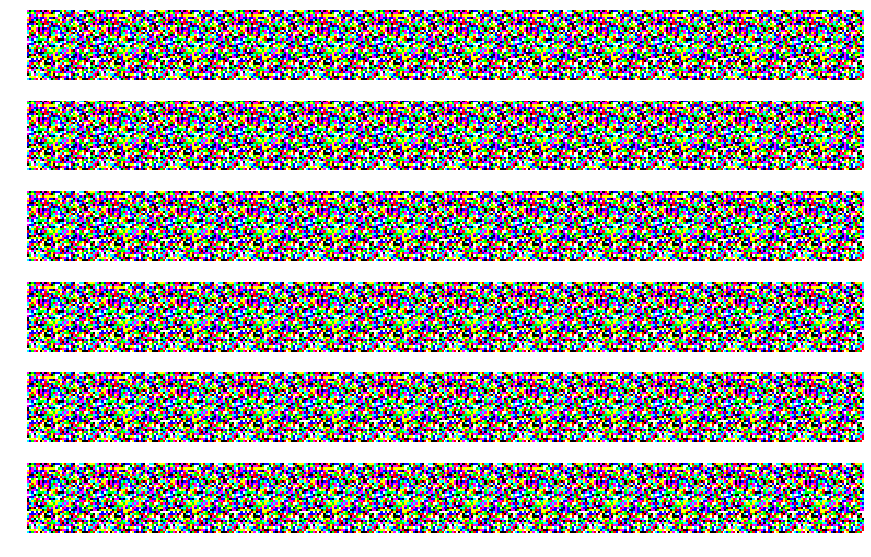

Epoch 14/111... Dloss: -28.5493 Gloss: -28.5493
Epoch 15/111... Dloss: -28.5213 Gloss: -28.5213
Epoch 15/111... Dloss: -28.5370 Gloss: -28.5370
Epoch 15/111... Dloss: -28.5253 Gloss: -28.5253
Epoch 15/111... Dloss: -28.5725 Gloss: -28.5725
Epoch 15/111... Dloss: -28.5336 Gloss: -28.5336
Epoch 15/111... Dloss: -28.5284 Gloss: -28.5284
Epoch 15/111... Dloss: -28.5336 Gloss: -28.5336
Epoch 15/111... Dloss: -28.5307 Gloss: -28.5307
Epoch 15/111... Dloss: -28.5473 Gloss: -28.5473


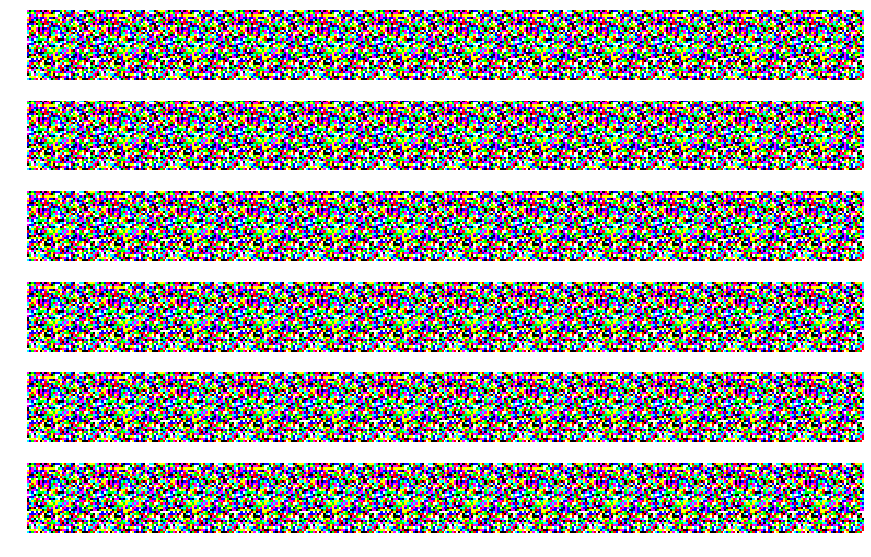

Epoch 15/111... Dloss: -28.5400 Gloss: -28.5400
Epoch 15/111... Dloss: -28.5474 Gloss: -28.5474
Epoch 15/111... Dloss: -28.5262 Gloss: -28.5262
Epoch 15/111... Dloss: -28.5724 Gloss: -28.5724
Epoch 15/111... Dloss: -28.5398 Gloss: -28.5398
Epoch 15/111... Dloss: -28.5442 Gloss: -28.5442
Epoch 15/111... Dloss: -28.5489 Gloss: -28.5489
Epoch 15/111... Dloss: -28.5506 Gloss: -28.5506
Epoch 15/111... Dloss: -28.5223 Gloss: -28.5223
Epoch 15/111... Dloss: -28.5389 Gloss: -28.5389


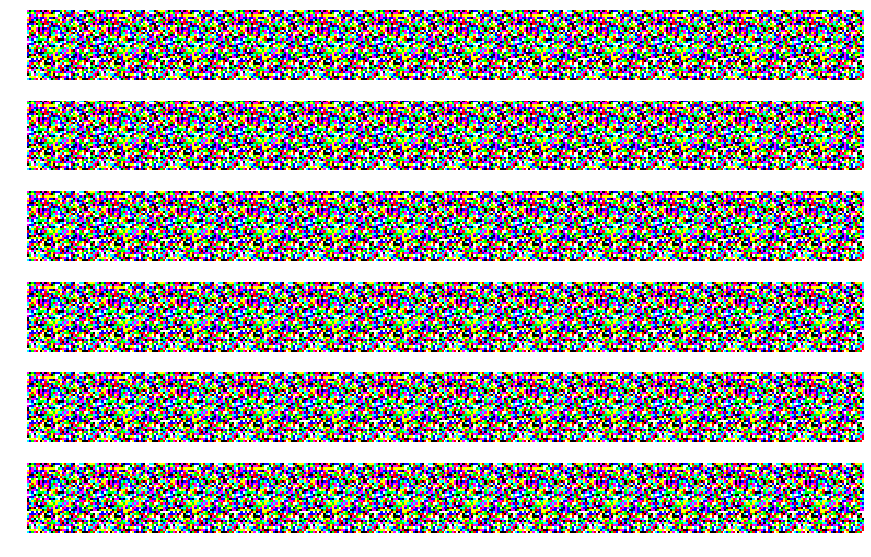

Epoch 15/111... Dloss: -28.5670 Gloss: -28.5670
Epoch 15/111... Dloss: -28.5741 Gloss: -28.5741
Epoch 15/111... Dloss: -28.5312 Gloss: -28.5312
Epoch 15/111... Dloss: -28.5633 Gloss: -28.5633
Epoch 15/111... Dloss: -28.5379 Gloss: -28.5379
Epoch 15/111... Dloss: -28.5459 Gloss: -28.5459
Epoch 15/111... Dloss: -28.5203 Gloss: -28.5203
Epoch 15/111... Dloss: -28.5643 Gloss: -28.5643
Epoch 15/111... Dloss: -28.5151 Gloss: -28.5151
Epoch 16/111... Dloss: -28.5152 Gloss: -28.5152


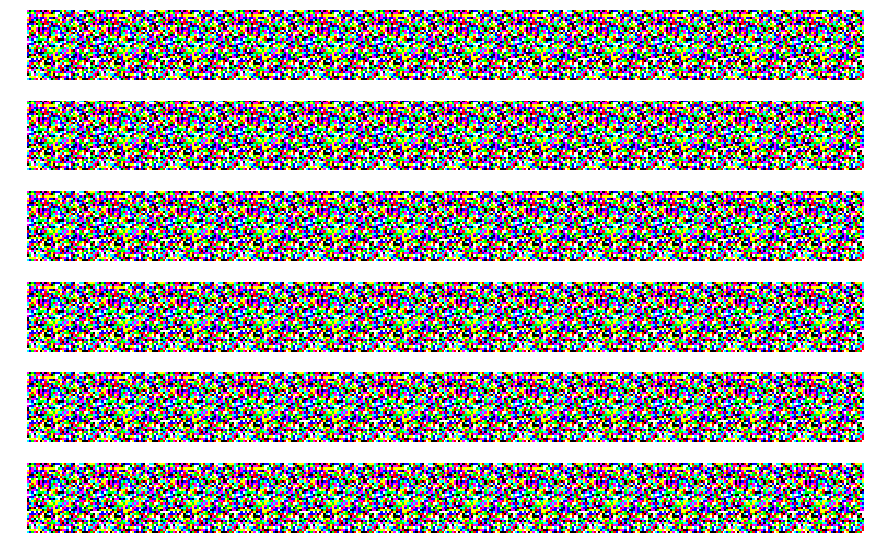

Epoch 16/111... Dloss: -28.5403 Gloss: -28.5403
Epoch 16/111... Dloss: -28.5710 Gloss: -28.5710
Epoch 16/111... Dloss: -28.5139 Gloss: -28.5139
Epoch 16/111... Dloss: -28.5425 Gloss: -28.5425
Epoch 16/111... Dloss: -28.5590 Gloss: -28.5590
Epoch 16/111... Dloss: -28.5266 Gloss: -28.5266
Epoch 16/111... Dloss: -28.5446 Gloss: -28.5446
Epoch 16/111... Dloss: -28.5475 Gloss: -28.5475
Epoch 16/111... Dloss: -28.5219 Gloss: -28.5219
Epoch 16/111... Dloss: -28.5610 Gloss: -28.5610


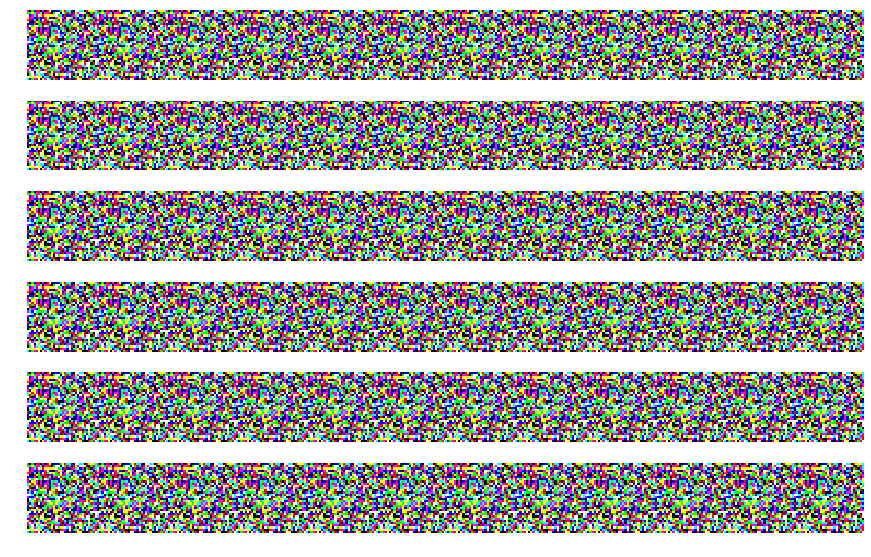

Epoch 16/111... Dloss: -28.5268 Gloss: -28.5268
Epoch 16/111... Dloss: -28.5439 Gloss: -28.5439
Epoch 16/111... Dloss: -28.5229 Gloss: -28.5229
Epoch 16/111... Dloss: -28.4984 Gloss: -28.4984
Epoch 16/111... Dloss: -28.5497 Gloss: -28.5497
Epoch 16/111... Dloss: -28.5375 Gloss: -28.5375
Epoch 16/111... Dloss: -28.5627 Gloss: -28.5627
Epoch 16/111... Dloss: -28.5557 Gloss: -28.5557
Epoch 16/111... Dloss: -28.4981 Gloss: -28.4981
Epoch 16/111... Dloss: -28.5638 Gloss: -28.5638


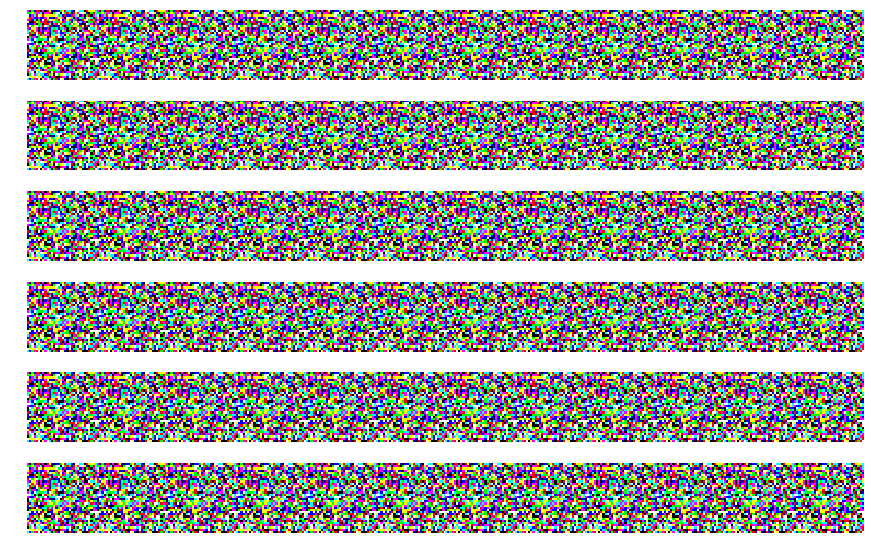

Epoch 16/111... Dloss: -28.5671 Gloss: -28.5671
Epoch 16/111... Dloss: -28.5440 Gloss: -28.5440
Epoch 16/111... Dloss: -28.5170 Gloss: -28.5170
Epoch 16/111... Dloss: -28.5599 Gloss: -28.5599
Epoch 16/111... Dloss: -28.5336 Gloss: -28.5336
Epoch 16/111... Dloss: -28.5177 Gloss: -28.5177
Epoch 16/111... Dloss: -28.5397 Gloss: -28.5397
Epoch 16/111... Dloss: -28.5367 Gloss: -28.5367
Epoch 17/111... Dloss: -28.5455 Gloss: -28.5455
Epoch 17/111... Dloss: -28.5444 Gloss: -28.5444


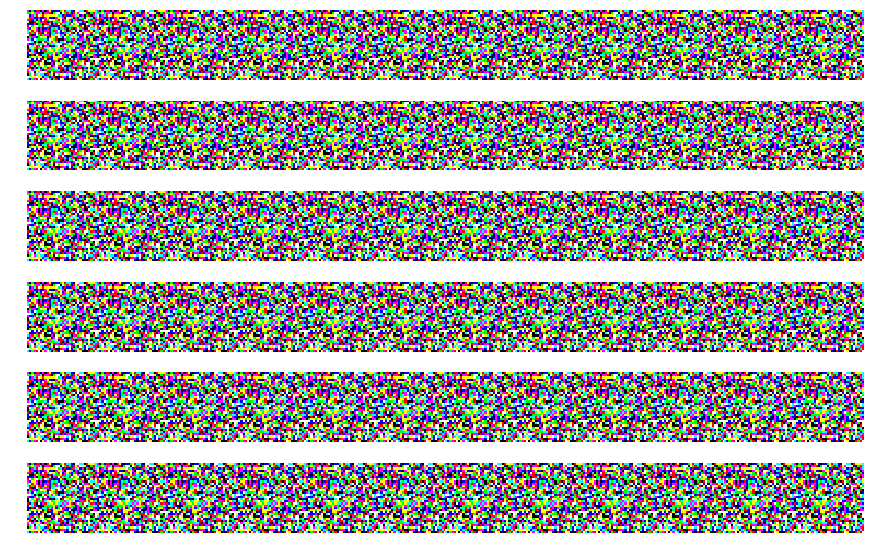

Epoch 17/111... Dloss: -28.5275 Gloss: -28.5275
Epoch 17/111... Dloss: -28.4912 Gloss: -28.4912
Epoch 17/111... Dloss: -28.5509 Gloss: -28.5509
Epoch 17/111... Dloss: -28.5250 Gloss: -28.5250
Epoch 17/111... Dloss: -28.5595 Gloss: -28.5595
Epoch 17/111... Dloss: -28.5625 Gloss: -28.5625
Epoch 17/111... Dloss: -28.5335 Gloss: -28.5335
Epoch 17/111... Dloss: -28.5383 Gloss: -28.5383
Epoch 17/111... Dloss: -28.5211 Gloss: -28.5211
Epoch 17/111... Dloss: -28.5718 Gloss: -28.5718


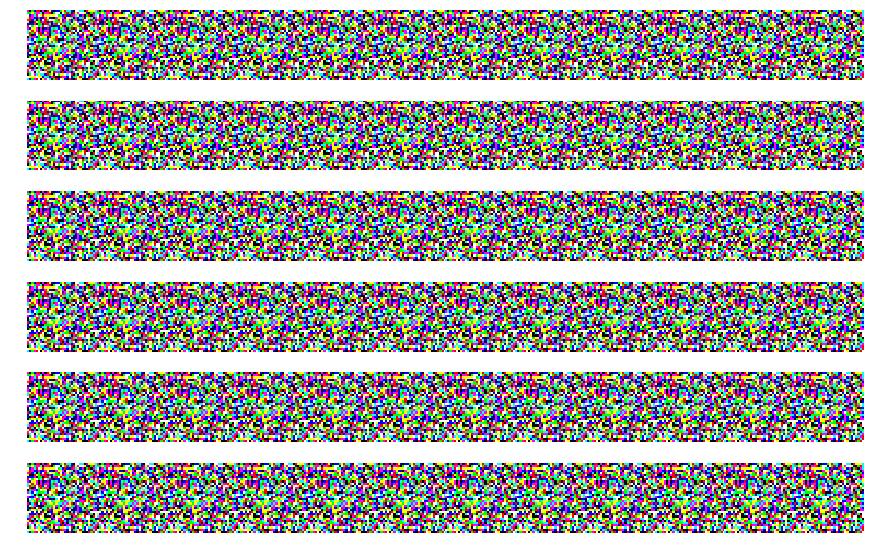

Epoch 17/111... Dloss: -28.5475 Gloss: -28.5475
Epoch 17/111... Dloss: -28.5503 Gloss: -28.5503
Epoch 17/111... Dloss: -28.5490 Gloss: -28.5490
Epoch 17/111... Dloss: -28.5422 Gloss: -28.5422
Epoch 17/111... Dloss: -28.5538 Gloss: -28.5538
Epoch 17/111... Dloss: -28.5606 Gloss: -28.5606
Epoch 17/111... Dloss: -28.5262 Gloss: -28.5262
Epoch 17/111... Dloss: -28.5184 Gloss: -28.5184
Epoch 17/111... Dloss: -28.5308 Gloss: -28.5308
Epoch 17/111... Dloss: -28.5437 Gloss: -28.5437


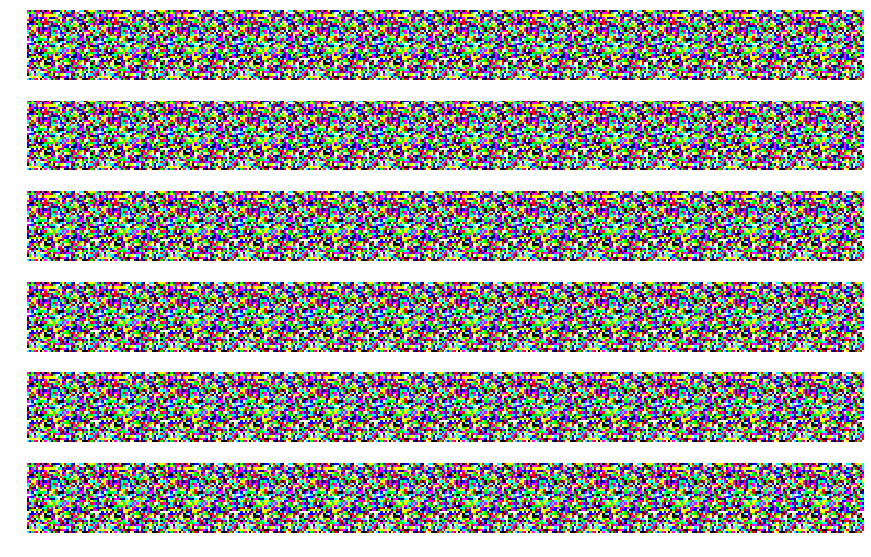

Epoch 17/111... Dloss: -28.5620 Gloss: -28.5620
Epoch 17/111... Dloss: -28.5185 Gloss: -28.5185
Epoch 17/111... Dloss: -28.5155 Gloss: -28.5155
Epoch 17/111... Dloss: -28.5314 Gloss: -28.5314
Epoch 17/111... Dloss: -28.5644 Gloss: -28.5644
Epoch 17/111... Dloss: -28.5547 Gloss: -28.5547
Epoch 17/111... Dloss: -28.5441 Gloss: -28.5441
Epoch 18/111... Dloss: -28.5695 Gloss: -28.5695
Epoch 18/111... Dloss: -28.5772 Gloss: -28.5772
Epoch 18/111... Dloss: -28.5507 Gloss: -28.5507


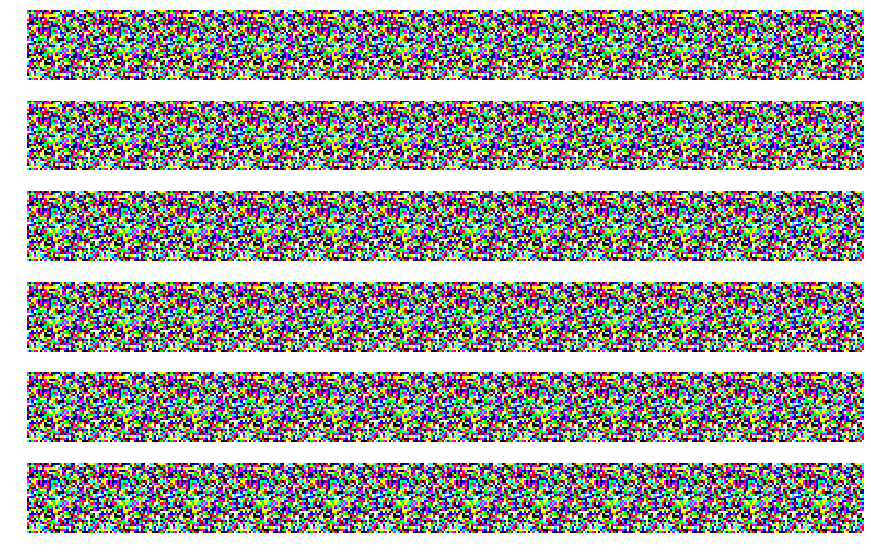

Epoch 18/111... Dloss: -28.5265 Gloss: -28.5265
Epoch 18/111... Dloss: -28.5184 Gloss: -28.5184
Epoch 18/111... Dloss: -28.5358 Gloss: -28.5358
Epoch 18/111... Dloss: -28.5327 Gloss: -28.5327
Epoch 18/111... Dloss: -28.5497 Gloss: -28.5497
Epoch 18/111... Dloss: -28.5483 Gloss: -28.5483
Epoch 18/111... Dloss: -28.5491 Gloss: -28.5491
Epoch 18/111... Dloss: -28.5777 Gloss: -28.5777
Epoch 18/111... Dloss: -28.5062 Gloss: -28.5062
Epoch 18/111... Dloss: -28.5168 Gloss: -28.5168


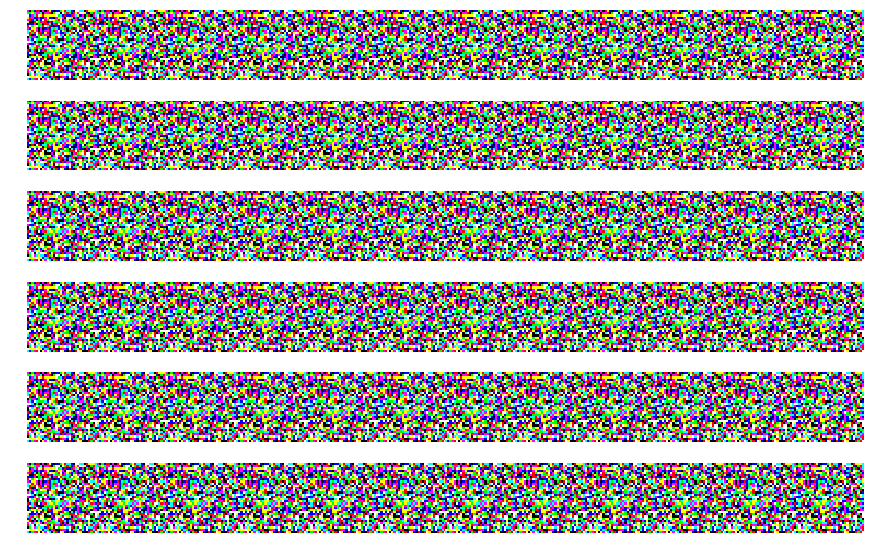

Epoch 18/111... Dloss: -28.5412 Gloss: -28.5412
Epoch 18/111... Dloss: -28.5311 Gloss: -28.5311
Epoch 18/111... Dloss: -28.5647 Gloss: -28.5647
Epoch 18/111... Dloss: -28.5938 Gloss: -28.5938
Epoch 18/111... Dloss: -28.5412 Gloss: -28.5412
Epoch 18/111... Dloss: -28.5571 Gloss: -28.5571
Epoch 18/111... Dloss: -28.5433 Gloss: -28.5433
Epoch 18/111... Dloss: -28.5256 Gloss: -28.5256
Epoch 18/111... Dloss: -28.5318 Gloss: -28.5318
Epoch 18/111... Dloss: -28.5898 Gloss: -28.5898


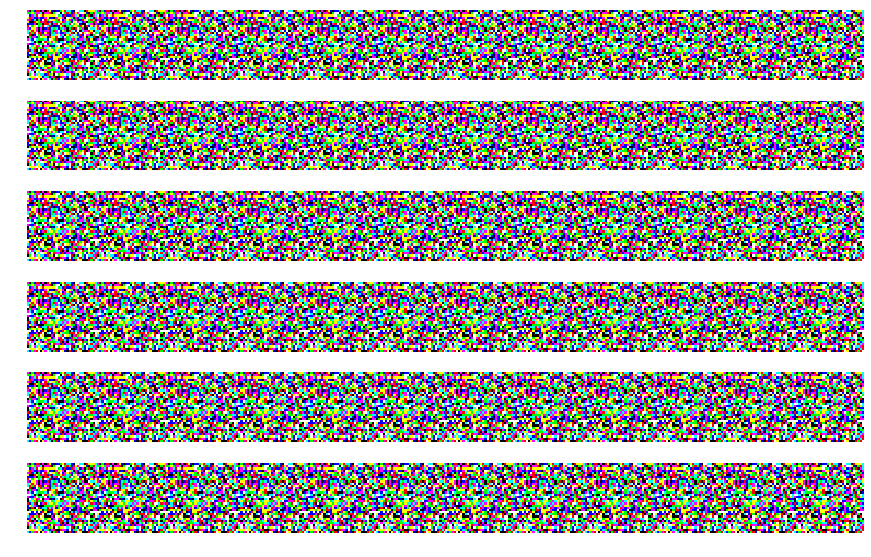

Epoch 18/111... Dloss: -28.5576 Gloss: -28.5576
Epoch 18/111... Dloss: -28.5805 Gloss: -28.5805
Epoch 18/111... Dloss: -28.5310 Gloss: -28.5310
Epoch 18/111... Dloss: -28.5473 Gloss: -28.5473
Epoch 18/111... Dloss: -28.5444 Gloss: -28.5444
Epoch 19/111... Dloss: -28.5470 Gloss: -28.5470
Epoch 19/111... Dloss: -28.4985 Gloss: -28.4985
Epoch 19/111... Dloss: -28.5250 Gloss: -28.5250
Epoch 19/111... Dloss: -28.5454 Gloss: -28.5454
Epoch 19/111... Dloss: -28.5393 Gloss: -28.5393


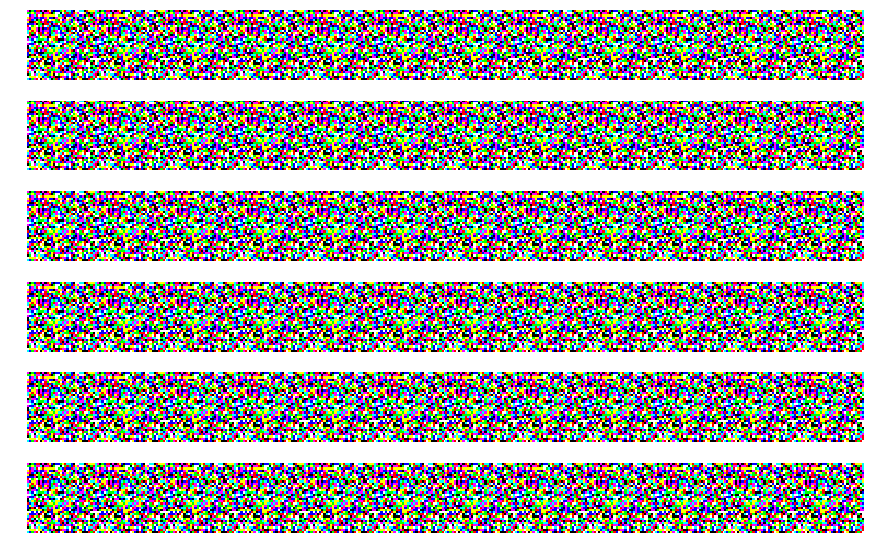

Epoch 19/111... Dloss: -28.5301 Gloss: -28.5301
Epoch 19/111... Dloss: -28.5502 Gloss: -28.5502
Epoch 19/111... Dloss: -28.5348 Gloss: -28.5348
Epoch 19/111... Dloss: -28.5313 Gloss: -28.5313
Epoch 19/111... Dloss: -28.5469 Gloss: -28.5469
Epoch 19/111... Dloss: -28.5232 Gloss: -28.5232
Epoch 19/111... Dloss: -28.5558 Gloss: -28.5558
Epoch 19/111... Dloss: -28.5436 Gloss: -28.5436
Epoch 19/111... Dloss: -28.5726 Gloss: -28.5726
Epoch 19/111... Dloss: -28.5786 Gloss: -28.5786


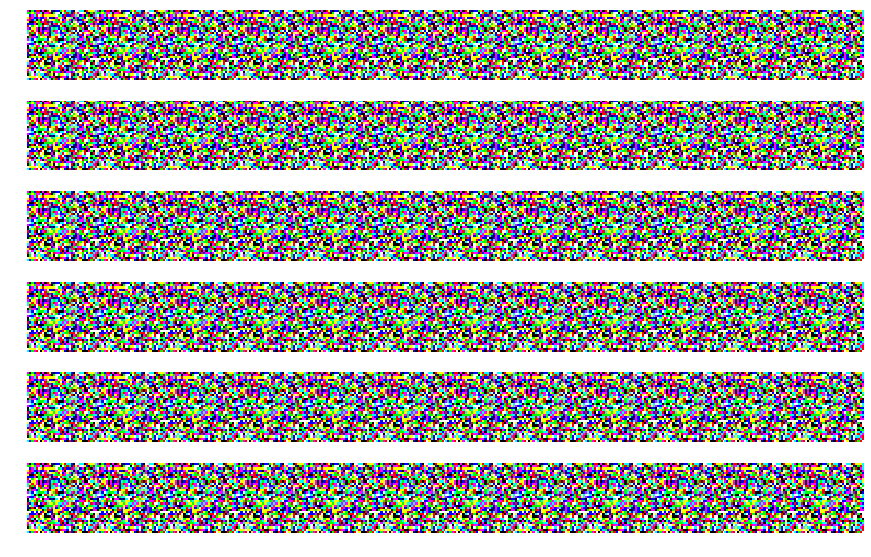

Epoch 19/111... Dloss: -28.5757 Gloss: -28.5757
Epoch 19/111... Dloss: -28.5678 Gloss: -28.5678
Epoch 19/111... Dloss: -28.5205 Gloss: -28.5205
Epoch 19/111... Dloss: -28.5295 Gloss: -28.5295
Epoch 19/111... Dloss: -28.5427 Gloss: -28.5427
Epoch 19/111... Dloss: -28.5396 Gloss: -28.5396
Epoch 19/111... Dloss: -28.5497 Gloss: -28.5497
Epoch 19/111... Dloss: -28.5700 Gloss: -28.5700
Epoch 19/111... Dloss: -28.5117 Gloss: -28.5117
Epoch 19/111... Dloss: -28.5798 Gloss: -28.5798


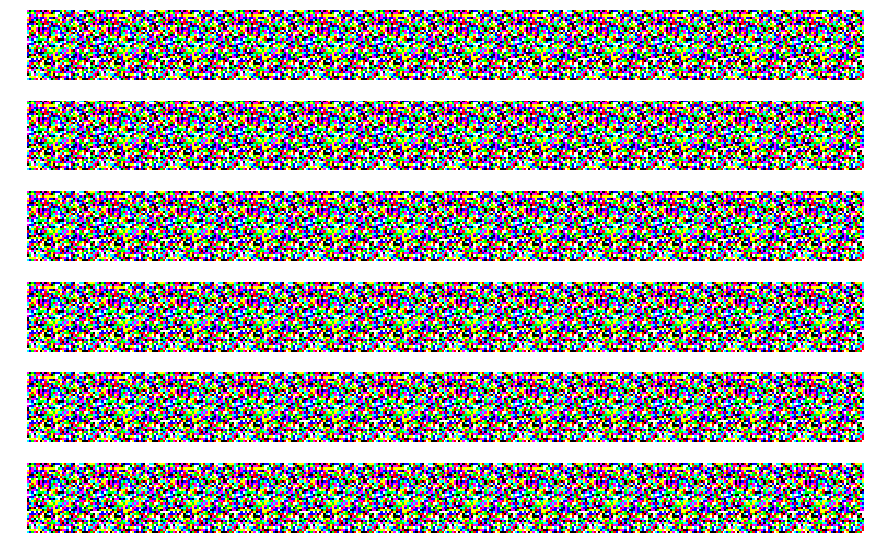

Epoch 19/111... Dloss: -28.5299 Gloss: -28.5299
Epoch 19/111... Dloss: -28.5478 Gloss: -28.5478
Epoch 19/111... Dloss: -28.5511 Gloss: -28.5511
Epoch 19/111... Dloss: -28.5486 Gloss: -28.5486
Epoch 20/111... Dloss: -28.5297 Gloss: -28.5297
Epoch 20/111... Dloss: -28.5524 Gloss: -28.5524
Epoch 20/111... Dloss: -28.5635 Gloss: -28.5635
Epoch 20/111... Dloss: -28.5370 Gloss: -28.5370
Epoch 20/111... Dloss: -28.5327 Gloss: -28.5327
Epoch 20/111... Dloss: -28.5385 Gloss: -28.5385


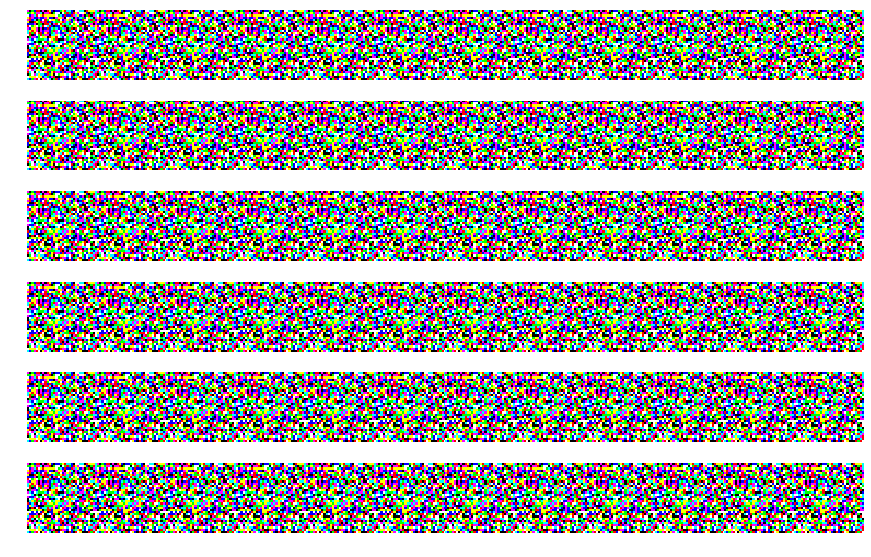

Epoch 20/111... Dloss: -28.5296 Gloss: -28.5296
Epoch 20/111... Dloss: -28.5587 Gloss: -28.5587
Epoch 20/111... Dloss: -28.5480 Gloss: -28.5480
Epoch 20/111... Dloss: -28.5247 Gloss: -28.5247
Epoch 20/111... Dloss: -28.5187 Gloss: -28.5187
Epoch 20/111... Dloss: -28.5194 Gloss: -28.5194
Epoch 20/111... Dloss: -28.5366 Gloss: -28.5366
Epoch 20/111... Dloss: -28.5308 Gloss: -28.5308
Epoch 20/111... Dloss: -28.5535 Gloss: -28.5535
Epoch 20/111... Dloss: -28.5207 Gloss: -28.5207


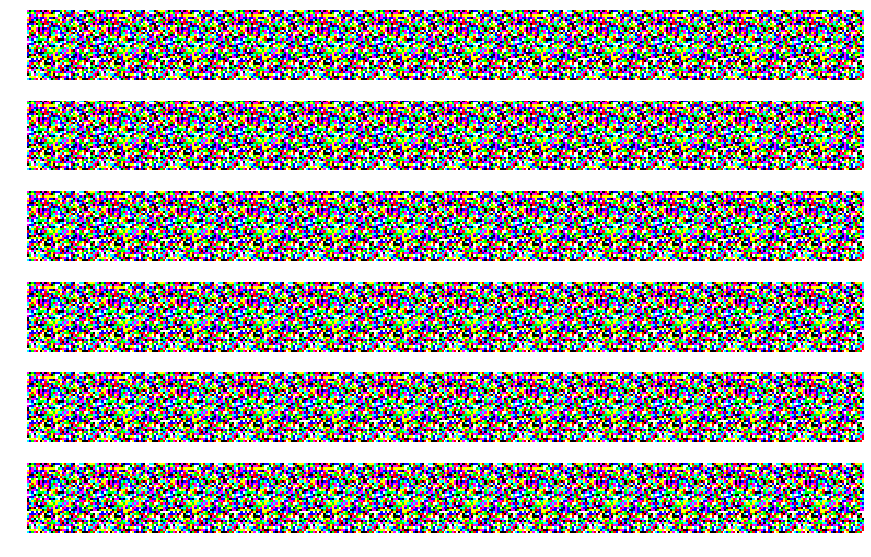

Epoch 20/111... Dloss: -28.5458 Gloss: -28.5458


In [ ]:
losses, samples = train(net=net, dataset=dataset, epochs=epochs, batch_size=batch_size, graph=graph) 
# figsize=(15,10) # W:15, H:10

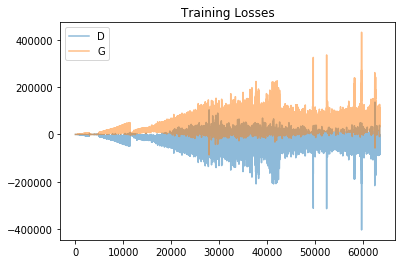

In [38]:
fig, ax = plt.subplots()
losses = np.array(losses)
# losses_norm = (losses_ - losses_.mean(axis=0))/losses_.std(axis=0)
# print(losses_.shape, losses_norm.shape, losses_norm.dtype, losses_norm.dtype)
plt.plot(losses.T[0], label='D', alpha=0.5)
plt.plot(losses.T[1], label='G', alpha=0.5)
plt.title("Training Losses")
plt.legend()

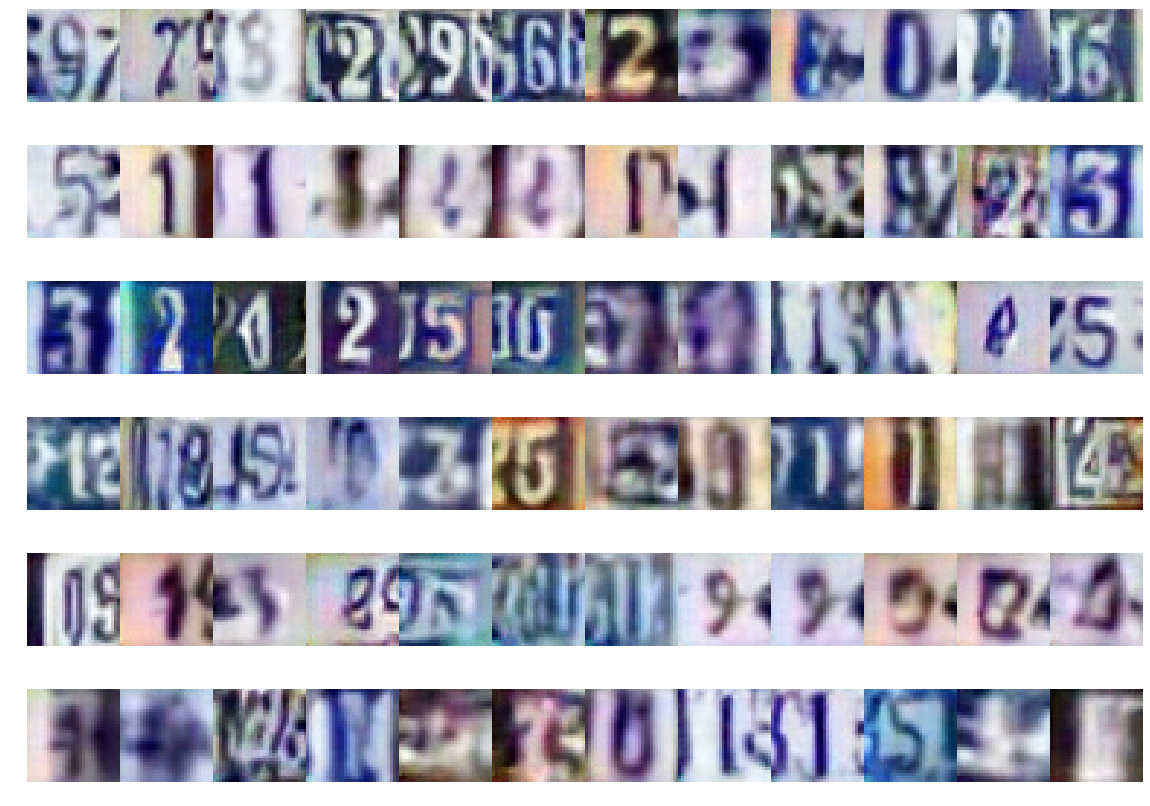

In [42]:
_ = view_samples(-1, samples, 6, 12, figsize=(20,15))

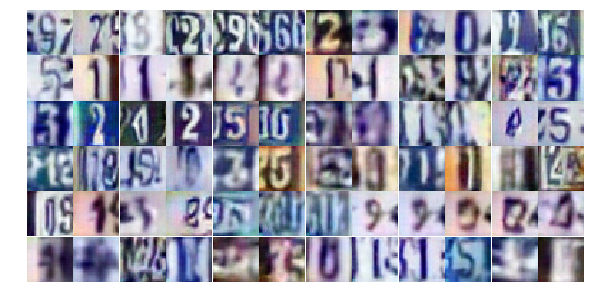

In [40]:
_ = view_samples(-1, samples, 6, 12, figsize=(10,5))

# Below are the older versions

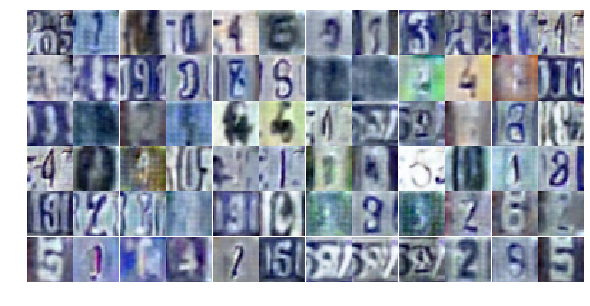

In [36]:
_ = view_samples(-1, samples, 6, 12, figsize=(10,5))

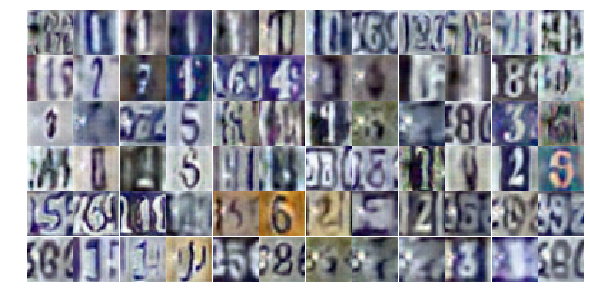

In [29]:
_ = view_samples(-1, samples, 6, 12, figsize=(10,5))

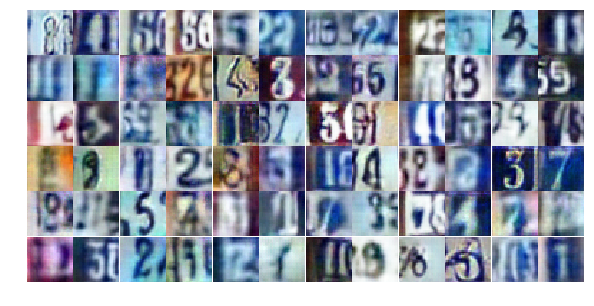

In [19]:
_ = view_samples(-1, samples, 6, 12, figsize=(10,5))